# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры. Для оценки качества моделей применяйте метрику RMSE. 
Значение метрики RMSE должно быть меньше 2500.

## Загрузка и подготовка данных

Импортируем необходимые библиотеки, объявим функции, зафиксируем рандомстейт.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import phik
import seaborn as sns
import time
import warnings

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor

In [6]:
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))

In [7]:
class ModelsStat:
    def __init__(self):
        self.models = []
        self.score_limit = 2500

    def add(self, name: str, params: str, fit_time: float, 
            predict_time: float, score: float) -> None:
        self.models.append({
            'model': name,
            'fit_time': fit_time,
            'predict_time': predict_time,
            'score': score,
            'params': params,
            'acceptable': True if score < self.score_limit else False,
        })

    def to_frame(self) -> pd.DataFrame:
        df = pd.DataFrame(self.models) \
             .sort_values(by=['acceptable', 'score'], ascending=[False, True]) \
             .reset_index(drop=True)
        for column in df.select_dtypes(include='number'):
            df[column] = np.round(df[column], 2)
        df.columns = ['Модель', 'Время обучения, сек', 'Время предсказания, сек', 
                      'RMSE на кросс-валидации, евро', 'Параметры', 'Модель подходит']
        return df


def display_box(s: pd.Series, name: str, ax: plt.Axes) -> None:
    s.plot(kind='box', vert=False, ax=ax, medianprops={'color': 'red'})
    ax.set_title(f'Диаграмма размаха признака {name}')
    ax.set_xlabel(name)
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.grid(axis='x', alpha=0.5, linestyle=':')


def display_residuals(y_true: pd.Series, y_pred: pd.Series, name: str, axes: (plt.Axes)) -> None:
    residuals = y_true - y_pred
    
    sns.histplot(x=residuals, ax=axes[0], kde=True, kde_kws={'bw_method': 0.2}, edgecolor='white', color='teal')
    axes[0].set_title(f'Распределения остатков\nмодели {name}')
    axes[0].set_xlabel('Остатки')
    axes[0].set_ylabel('Количество')
    axes[0].spines['top'].set_visible(False)
    axes[0].spines['right'].set_visible(False)

    sns.scatterplot(x=y_pred, y=residuals, ax=axes[1], alpha=0.3, color='teal', marker='+')
    axes[1].set_title(f'Анализ дисперсии\nмодели {name}')
    axes[1].set_xlabel('Предсказания')
    axes[1].set_ylabel('Остатки')
    axes[1].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)
    axes[1].grid(alpha=0.5, linestyle=':')


def get_cv_results(gscv: GridSearchCV) -> list[float]:
    best_params = gscv.best_estimator_.named_steps['model'].get_params()
    display('Гиперпараметры лучшей модели: ' + str(best_params))
    
    fit_time = gscv.cv_results_['mean_fit_time'][gscv.best_index_]
    display(f'Время обучения: {fit_time:.2f} s')
    
    predict_time = gscv.cv_results_['mean_score_time'][gscv.best_index_]
    display(f'Время предсказания: {predict_time:.2f} s')
    
    score = -gscv.best_score_
    display(f'RMSE при кросс-валидации: {score:.2f} евро')

    return str(best_params), fit_time, predict_time, score

In [8]:
BRAND_FOUNDATION = {
    'alfa_romeo': 1910, 'audi': 1909, 'bmw': 1916, 'chevrolet': 1911, 'chrysler': 1925, 
    'citroen': 1919, 'dacia': 1966, 'daewoo': 1967, 'daihatsu': 1907, 'fiat': 1899, 
    'ford': 1903, 'honda': 1948, 'hyundai': 1967, 'jaguar': 1922, 'jeep': 1941, 
    'kia': 1944, 'lada': 1966, 'lancia': 1906, 'land_rover': 1948, 'mazda': 1931,
    'mercedes_benz': 1926, 'mini': 1959, 'mitsubishi': 1870, 'nissan': 1933, 'opel': 1899, 
    'peugeot': 1889, 'porsche': 1931, 'renault': 1899, 'saab': 1945, 
    'seat': 1950, 'skoda': 1895, 'smart': 1994, 'other': 1885 , 'subaru': 1953, 
    'suzuki': 1909, 'toyota': 1937, 'trabant': 1957, 'volkswagen': 1937, 'volvo': 1927
}
RANDOM_STATE = 42

### Загрузка данных

Считаем CSV-файл с данными и сохраним его в `autos`. Изучим общую информацию о датафрейме.

In [11]:
csv_local = 'datasets/autos.csv'
csv_remote = 'https://example.com/datasets/autos.csv'
if os.path.exists(csv_local):
    autos = pd.read_csv(csv_local, parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
else:
    autos = pd.read_csv(csv_remote, parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])

In [12]:
INITIAL_ROWS_COUNT = autos.shape[0]

In [13]:
autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [14]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

Датафрейм `autos`с данными о технических характеристиках, комплектации и ценах автомобилей содержит следующие признаки:
- `DateCrawled` — дата скачивания анкеты из базы;
- `Price` — цена (евро), **целевой признак**;
- `VehicleType` — тип автомобильного кузова;
- `RegistrationYear` — год регистрации автомобиля;
- `Gearbox` — тип коробки передач;
- `Power` — мощность (л. с.);
- `Model` — модель автомобиля;
- `Kilometer` — пробег (км);
- `RegistrationMonth` — месяц регистрации автомобиля;
- `FuelType` — тип топлива;
- `Brand` — марка автомобиля;
- `Repaired` — была машина в ремонте или нет;
- `DateCreated` — дата создания анкеты;
- `NumberOfPictures` — количество фотографий автомобиля;
- `PostalCode` — почтовый индекс владельца анкеты (пользователя);
- `LastSeen` — дата последней активности пользователя.

### Предобработка данных

#### Общая информация о признаках

Посмотрим на числовое описание количественных признаков.

In [19]:
num_columns = ['DateCrawled', 'Price', 'RegistrationYear', 'Power', 'Kilometer', 
               'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen']
autos[num_columns].describe().T

,count,mean,min,25%,50%,75%,max,std
DateCrawled,354369,2016-03-21 12:58:10.450648320,2016-03-05 14:06:22,2016-03-13 11:52:33,2016-03-21 17:50:55,2016-03-29 14:37:20,2016-04-07 14:36:58,NaN
Price,354369.0,4416.656776,0.0,1050.0,2700.0,6400.0,20000.0,4514.158514
RegistrationYear,354369.0,2004.234448,1000.0,1999.0,2003.0,2008.0,9999.0,90.227958
Power,354369.0,110.094337,0.0,69.0,105.0,143.0,20000.0,189.850405
Kilometer,354369.0,128211.172535,5000.0,125000.0,150000.0,150000.0,150000.0,37905.34153
RegistrationMonth,354369.0,5.714645,0.0,3.0,6.0,9.0,12.0,3.726421
DateCreated,354369,2016-03-20 19:12:07.753274112,2014-03-10 00:00:00,2016-03-13 00:00:00,2016-03-21 00:00:00,2016-03-29 00:00:00,2016-04-07 00:00:00,NaN
NumberOfPictures,354369.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,1067.0,30165.0,49413.0,71083.0,99998.0,25783.096248
LastSeen,354369,2016-03-29 23:51:00.667456768,2016-03-05 14:15:08,2016-03-23 02:50:03,2016-04-03 15:15:51,2016-04-06 10:15:19,2016-04-07 14:58:51,NaN


Посмотрим на числовое описание категориальных признаков.

In [21]:
cat_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
autos[cat_columns].describe().T

,count,unique,top,freq
VehicleType,316879,8,sedan,91457
Gearbox,334536,2,manual,268251
Model,334664,250,golf,29232
FuelType,321474,7,petrol,216352
Brand,354369,40,volkswagen,77013
Repaired,283215,2,no,247161


Проверим пропуски.

In [23]:
autos.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Замечено несколько проблем с данными:
- пропуски в признаках `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Repaired`;
- нулевые значения (по сути пропуски) в признаках `Price`, `Power`, `RegistrationMonth`, `NumberOfPictures`.

Проверим наличие явных дубликатов.

In [26]:
autos.duplicated().sum()

4

Удалим явные дубликаты.

In [28]:
autos = autos.drop_duplicates()

Теперь обработаем каждый из признаков.

#### Цена (евро)

Посмотрим на числовое описание признака.

In [32]:
autos['Price'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
Price,354365.0,4416.67983,4514.176349,0.0,1050.0,2700.0,6400.0,20000.0


Есть проблемы с диапазоном значений признака (минимальное значение). Проверим пропуски.

In [34]:
autos['Price'].isna().sum()

0

Пропусков нет. Построим диаграмму размаха.

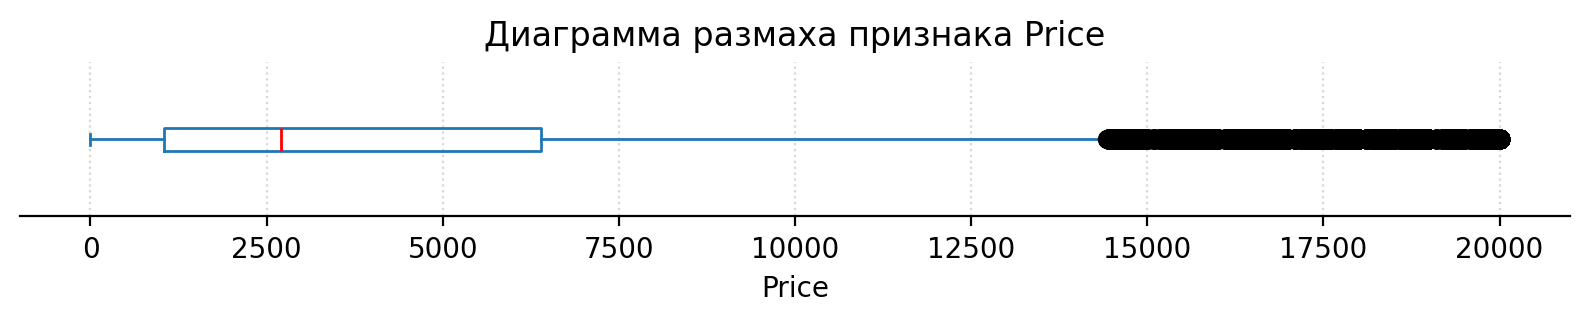

In [36]:
fig, ax = plt.subplots(figsize=(10, 1))
display_box(autos['Price'], 'Price', ax)
plt.show()

Проверим процент записей с нулевым значением признака.

In [38]:
pct = autos[autos['Price'] == 0].shape[0] / INITIAL_ROWS_COUNT * 100
f'{pct:.2f}%'

'3.04%'

Удаляем записи с нулевым значением признака.

In [40]:
autos = autos.drop(autos[autos['Price'] == 0].index)

#### Марка автомобиля

Проверим пропуски.

In [43]:
autos['Brand'].isna().sum()

0

Пропусков нет. Посмотрим на уникальные значения признака.

In [45]:
autos['Brand'].sort_values().unique()

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

Скрытых дубликатов в уникальных значениях признака нет. Заменим значение `sonstige_autos` на более очевидное `other`.

In [47]:
autos['Brand'] = autos['Brand'].where(autos['Brand'] != 'sonstige_autos', 'other')

#### Модель автомобиля

Проверим процент записей с пропусками.

In [50]:
pct = autos['Model'].isna().sum() / INITIAL_ROWS_COUNT * 100
f'{pct:.2f}%'

'4.94%'

Заменим пропуски на значение `unknown`.

In [52]:
autos['Model'] = autos['Model'].fillna('unknown')

Посмотрим на уникальные значения признака, сгруппировав данные по марке автомобиля.

In [54]:
autos.groupby('Brand', as_index=False)['Model'].agg(lambda x: ', '.join(sorted(x.unique())))

,Brand,Model
0,alfa_romeo,"145, 147, 156, 159, other, spider, unknown"
1,audi,"100, 200, 80, 90, a1, a2, a3, a4, a5, a6, a8, other, q3, q5, q7, tt, unknown"
2,bmw,"1er, 3er, 5er, 6er, 7er, i3, m_reihe, other, unknown, x_reihe, z_reihe"
3,chevrolet,"aveo, captiva, matiz, other, spark, unknown"
4,chrysler,"300c, crossfire, grand, other, ptcruiser, unknown, voyager"
5,citroen,"berlingo, c1, c2, c3, c4, c5, other, unknown"
6,dacia,"duster, lodgy, logan, other, sandero, unknown"
7,daewoo,"kalos, lanos, matiz, nubira, other, unknown"
8,daihatsu,"charade, cuore, materia, move, other, sirion, terios, unknown"
9,fiat,"500, bravo, croma, doblo, ducato, other, panda, punto, seicento, stilo, unknown"


Необходимо объединить марки `land_rover` и `rover` в одну.

In [56]:
autos['Brand'] = autos['Brand'].where(autos['Brand'] != 'rover', 'land_rover')
autos['Model'] = autos['Model'].where(autos['Model'] != 'rangerover', 'range_rover')

Также есть проблема со однинаковыми значениями признака для разных марок автомобилей. Например, есть одинаковые названия модели `grand` для марок `jeep` и `suzuki`. Обучаемые модели примут их за одну категорию — при том, что это совершенно разные автомобили. Избавимся от проблемы, склеив название модели с маркой.

In [58]:
autos['Model'] = autos['Brand'] + '_' + autos['Model']

#### Год регистрации автомобиля

Посмотрим на числовое описание признака.

In [61]:
autos['RegistrationYear'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
RegistrationYear,343593.0,2004.08983,78.41368,1000.0,1999.0,2003.0,2008.0,9999.0


Есть проблемы с диапазоном значений признака (минимальное и максимальное значения). Проверим пропуски.

In [63]:
autos['RegistrationYear'].isna().sum()

0

Пропусков нет. Построим диаграмму размаха.

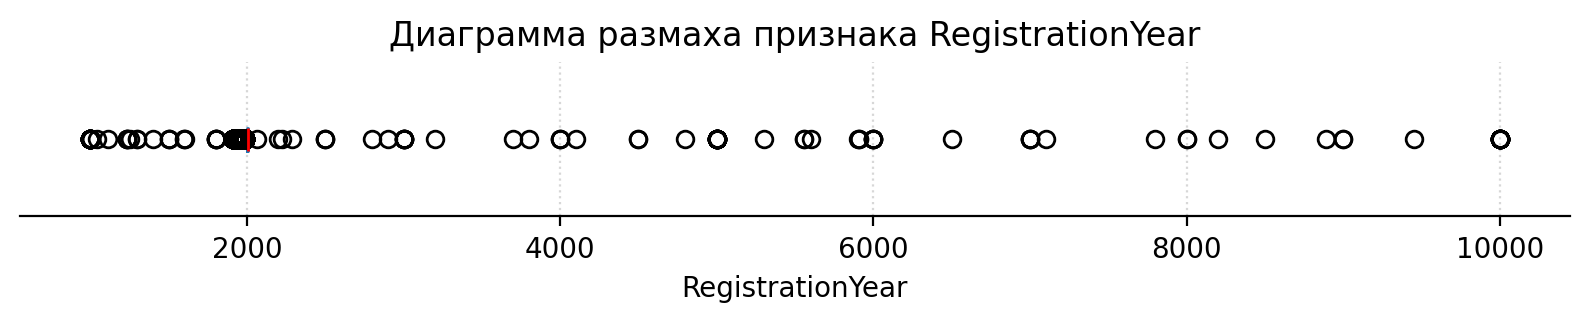

In [65]:
fig, ax = plt.subplots(figsize=(10, 1))
display_box(autos['RegistrationYear'], 'RegistrationYear', ax)
plt.show()

Проверим процент записей с некорректными значениями признака (у которых год регистрации меньше года основания марки автомобиля или больше, чем год выгрузки анкеты).

In [67]:
incorrect_rows_idxs = autos[autos.apply(lambda x: x['RegistrationYear'] < BRAND_FOUNDATION[x['Brand']] or \
                                                  x['RegistrationYear'] > x['DateCrawled'].year, 
                                        axis=1)].index
f'{len(incorrect_rows_idxs) / INITIAL_ROWS_COUNT * 100:.2f}%'

'3.91%'

Удаляем записи с некорректными значениями признака.

In [69]:
autos = autos.drop(incorrect_rows_idxs)

#### Тип автомобильного кузова, тип коробки передач, тип топлива, была машина в ремонте или нет

Проверим процент записей с пропусками.

In [72]:
columns = ['VehicleType', 'Gearbox', 'FuelType', 'Repaired']
for column in columns:
    print(f'{column}: {autos[column].isna().sum() / INITIAL_ROWS_COUNT * 100:.2f}%')

VehicleType: 5.62%
Gearbox: 4.40%
FuelType: 6.82%
Repaired: 16.89%


Заменим пропуски на значение `unknown` (также можно заменить пропуски на самые частые значения для каждой модели автомобиля, например).

In [74]:
for column in columns:
    autos[column] = autos[column].fillna('unknown')

Посмотрим на уникальные значения признаков.

In [76]:
for column in columns:
    uniq_vals = ', '.join(sorted(autos[column].unique()))
    print(f'{column}: {uniq_vals}')

VehicleType: bus, convertible, coupe, other, sedan, small, suv, unknown, wagon
Gearbox: auto, manual, unknown
FuelType: cng, electric, gasoline, hybrid, lpg, other, petrol, unknown
Repaired: no, unknown, yes


Есть скрытые дубликаты в значениях признака `FuelType` — `gasoline` и `petrol` означают бензин. Объединим их.

In [78]:
autos['FuelType'] = autos['FuelType'].where(autos['FuelType'] != 'gasoline', 'petrol')

Других скрытых дубликатов в уникальных значениях признаков нет.

#### Мощность (л. с.)

Посмотрим на числовое описание признака.

In [82]:
autos['Power'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
Power,329734.0,111.909363,184.855434,0.0,71.0,105.0,143.0,20000.0


Есть проблемы с диапазоном значений признака (минимальное и максимальное значения). Проверим пропуски.

In [84]:
autos['Power'].isna().sum()

0

Пропусков нет. Построим диаграмму размаха.

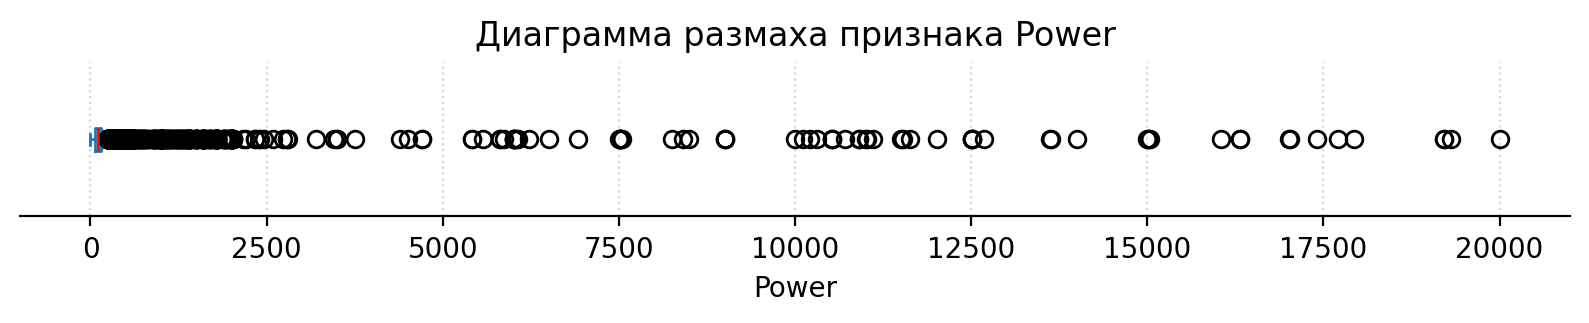

In [86]:
fig, ax = plt.subplots(figsize=(10, 1))
display_box(autos['Power'], 'Power', ax)
plt.show()

Проверим процент записей с некорректными значениями признака (у которых мощность равна 0 или более 1000 л. с.).

In [88]:
autos['IncorrectPower'] = (autos['Power'] == 0) | (autos['Power'] > 1000)
pct = autos['IncorrectPower'].sum() / INITIAL_ROWS_COUNT * 100
f'{pct:.2f}%'

'9.34%'

Таких записей слишком много — удалять не будем. Попробуем заменить некорректные значения мощности на средние значения для каждой модели автомобиля.

In [90]:
autos['Power'] = autos['Power'].where(autos['IncorrectPower'] == False, 
                                      autos.groupby('Model')['Power'].transform('median'))

Поскольку не для всех моделей могли найтись медианные значения мощности, проверим процент записей с некорректными значениями признака еще раз.

In [92]:
autos['IncorrectPower'] = (autos['Power'] == 0) | (autos['Power'] > 1000)
pct = autos['IncorrectPower'].sum() / INITIAL_ROWS_COUNT * 100
f'{pct:.2f}%'

'0.02%'

Удаляем оставшиеся записи с некорректными значениями признака.

In [94]:
autos = autos.drop(autos[autos['IncorrectPower']].index)
autos = autos.drop('IncorrectPower', axis=1)

#### Пробег (км) 

Посмотрим на числовое описание признака.

In [97]:
autos['Kilometer'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
Kilometer,329673.0,128223.269725,37503.386972,5000.0,125000.0,150000.0,150000.0,150000.0


Проблем с диапазоном значений признака нет. Проверим пропуски.

In [99]:
autos['Kilometer'].isna().sum()

0

Пропусков нет. Посмотрим диаграмму размаха.

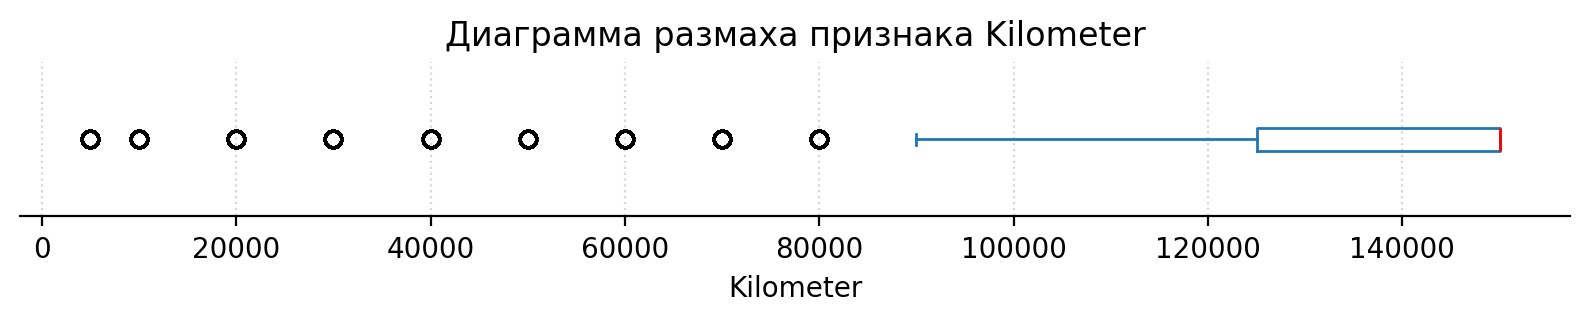

In [101]:
fig, ax = plt.subplots(figsize=(10, 1))
display_box(autos['Kilometer'], 'Kilometer', ax)
plt.show()

Выглядит странно — значения признака обрезаны справа на 150000 км. Не самая лучшая выборка. Посмотрим на уникальные значения признака.

In [103]:
autos['Kilometer'].sort_values().unique()

array([  5000,  10000,  20000,  30000,  40000,  50000,  60000,  70000,
        80000,  90000, 100000, 125000, 150000], dtype=int64)

Вероятно при создании анкет пробег выбирался из предустановленных категорий (например, `до 5 тыс. км`, `до 10 тыс. км` и так далее), а не заполнялся вручную.

#### Почтовый индекс владельца анкеты (пользователя)

Посмотрим на числовое описание признака.

In [107]:
autos['PostalCode'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
PostalCode,329673.0,50780.240708,25765.004008,1067.0,30457.0,49624.0,71336.0,99998.0


Проверим пропуски.

In [109]:
autos['PostalCode'].isna().sum()

0

Пропусков нет. Посмотрим на количество уникальных значений признака.

In [111]:
len(autos['PostalCode'].sort_values().unique())

8133

In [112]:
autos['PostalCode'].max()

99998

Посмотрели — более 8 тысяч уникальных значений категориального признака, слишком много. Выцепить из почтового адреса ценную информацию (город или страну) не получится. Почтовые индексы из разных стран могут совпадать, например, почтовый индекс `1067` может с равной вероятностью принадлежать как Копенгагену, так и Будапешту. Поэтому отнесем почтовый индекс владельца анкеты к неинформативным признакам.

#### Неинформативные признаки

К неинформативным признакам можно отнести:
- `DateCrawled` — дата скачивания анкеты из базы. Дата скачивания кем — владельцем анкеты или каким-то парсером? Если парсером, то каким образом могли появится записи с датой последней активности пользователя `LastSeen` большей, чем дата скачивания?
- `DateCreated` — дата создания анкеты. Казалось бы, полезный признак. Однако он не дает понимания о цене на момент продажи автомобиля. При создании анкеты могла быть указана совершенно другая цена.
- `LastSeen` — дата последней активности пользователя. Этот признак можно было бы притянуть к дате продажи автомобиля, однако все значения сосредоточены в промежутке всего лишь 34 дней в 2016 году — то есть это не даст никакого понимания динамики цен на автомобили в течение значимого периода.
- `NumberOfPictures` — количество фотографий автомобиля. У всех записей 0 фото.
- `RegistrationMonth` — месяц регистрации автомобиля. Вряд ли этот признак имеет хоть какое-то значения для автомобилей 5-10-20-летней давности. Да и оценить сезонность цен на автомобили вряд ли получится — ведь это месяц регистрации, а не месяц, в котором автомобиль продан.
- `PostalCode` — почтовый индекс владельца анкеты. Слишком много уникальных значений.

Удаляем неинформативные признаки.

In [116]:
useless_columns = ['DateCrawled', 'DateCreated', 'LastSeen', 
                   'NumberOfPictures', 'RegistrationMonth', 'PostalCode']
autos = autos.drop(useless_columns, axis=1)

Проверим явные дубликаты после удаления неинформативных признаков.

In [118]:
autos.duplicated().sum()

44377

Появились дубликаты, которые могу помешать обучиться модели линейной регрессии (если будем ее использовать). Однако будут полезны, например, для модели k-ближайших соседей (если будем ее использовать). Так что пока оставим дубликаты.

#### Результаты предобработки

Посмотрим на предобработанный датафрейм `autos`.

In [122]:
autos.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,unknown,1993,manual,100.0,volkswagen_golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190.0,audi_unknown,125000,petrol,audi,yes
2,9800,suv,2004,auto,163.0,jeep_grand,125000,petrol,jeep,unknown
3,1500,small,2001,manual,75.0,volkswagen_golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69.0,skoda_fabia,90000,petrol,skoda,no


Проверим пропуски.

In [124]:
autos.isna().sum().sum()

0

Пропусков не осталось. Посмотрим процент записей, которые были удалены.

In [126]:
f'{(1 - autos.shape[0] / INITIAL_ROWS_COUNT) * 100:.2f}%'

'6.97%'

В результате **предобработки данных** было удалено ~7% данных. Заполнены пропущенные значения и обработаны аномалии в признаках. Также было удалено 6 неинформативных признаков.

### Исследовательский анализ данных

#### Количественные признаки

Изучим распределения количественных признаков.

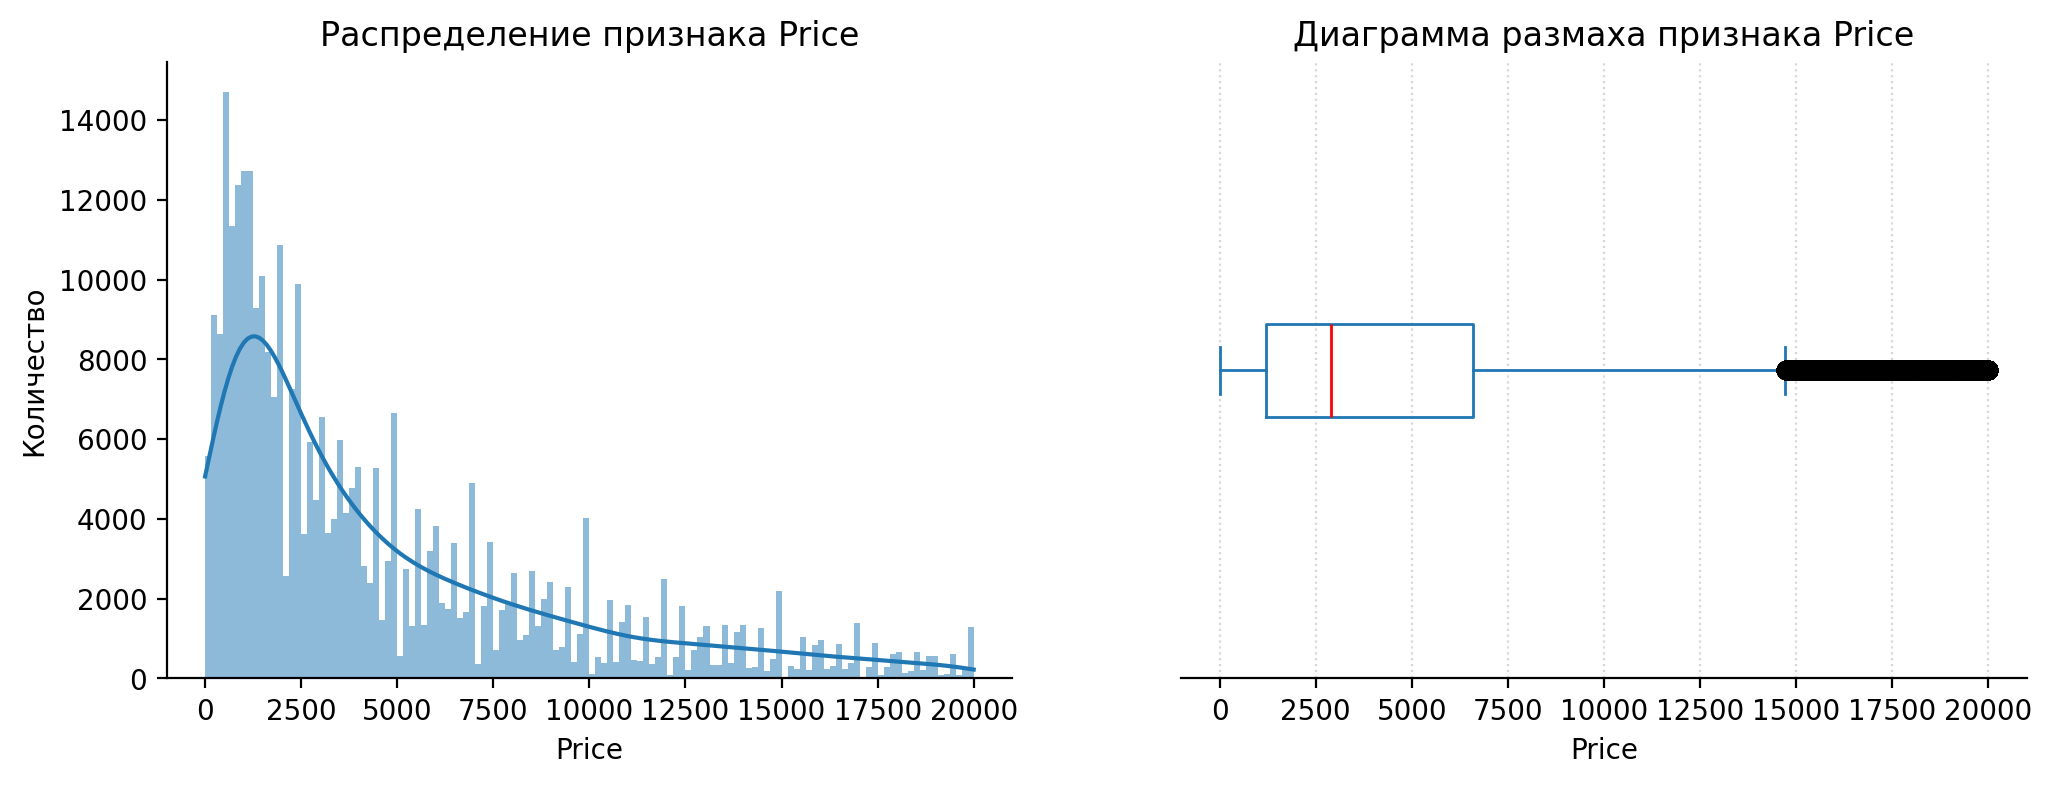

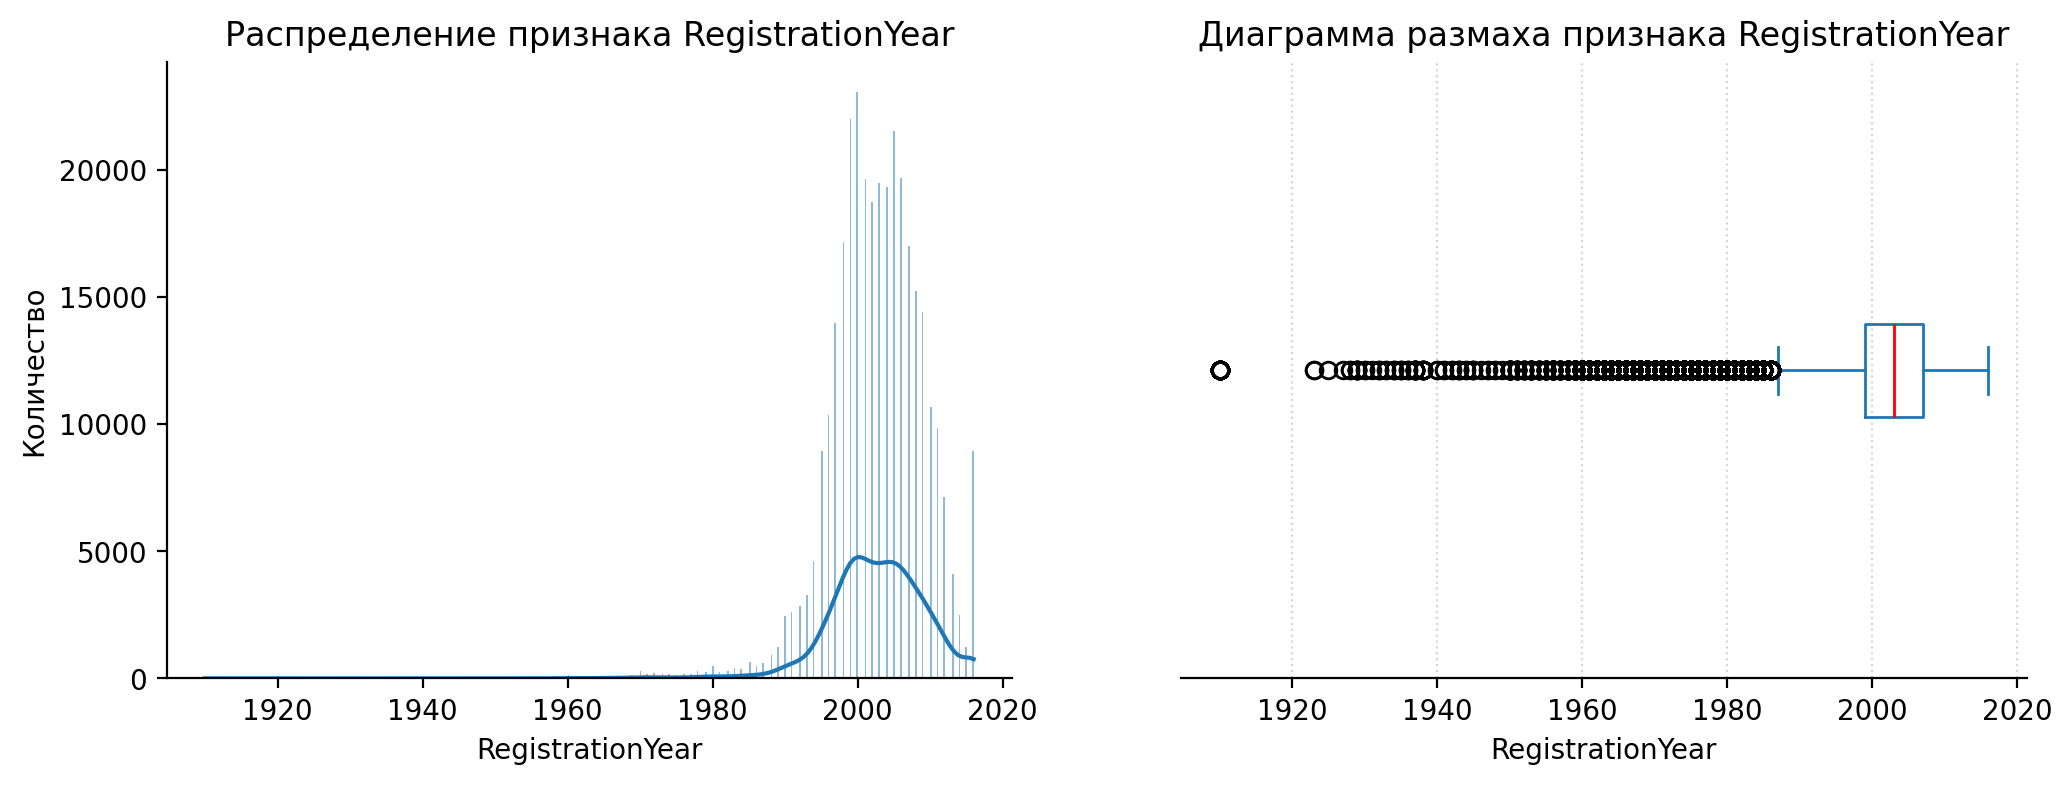

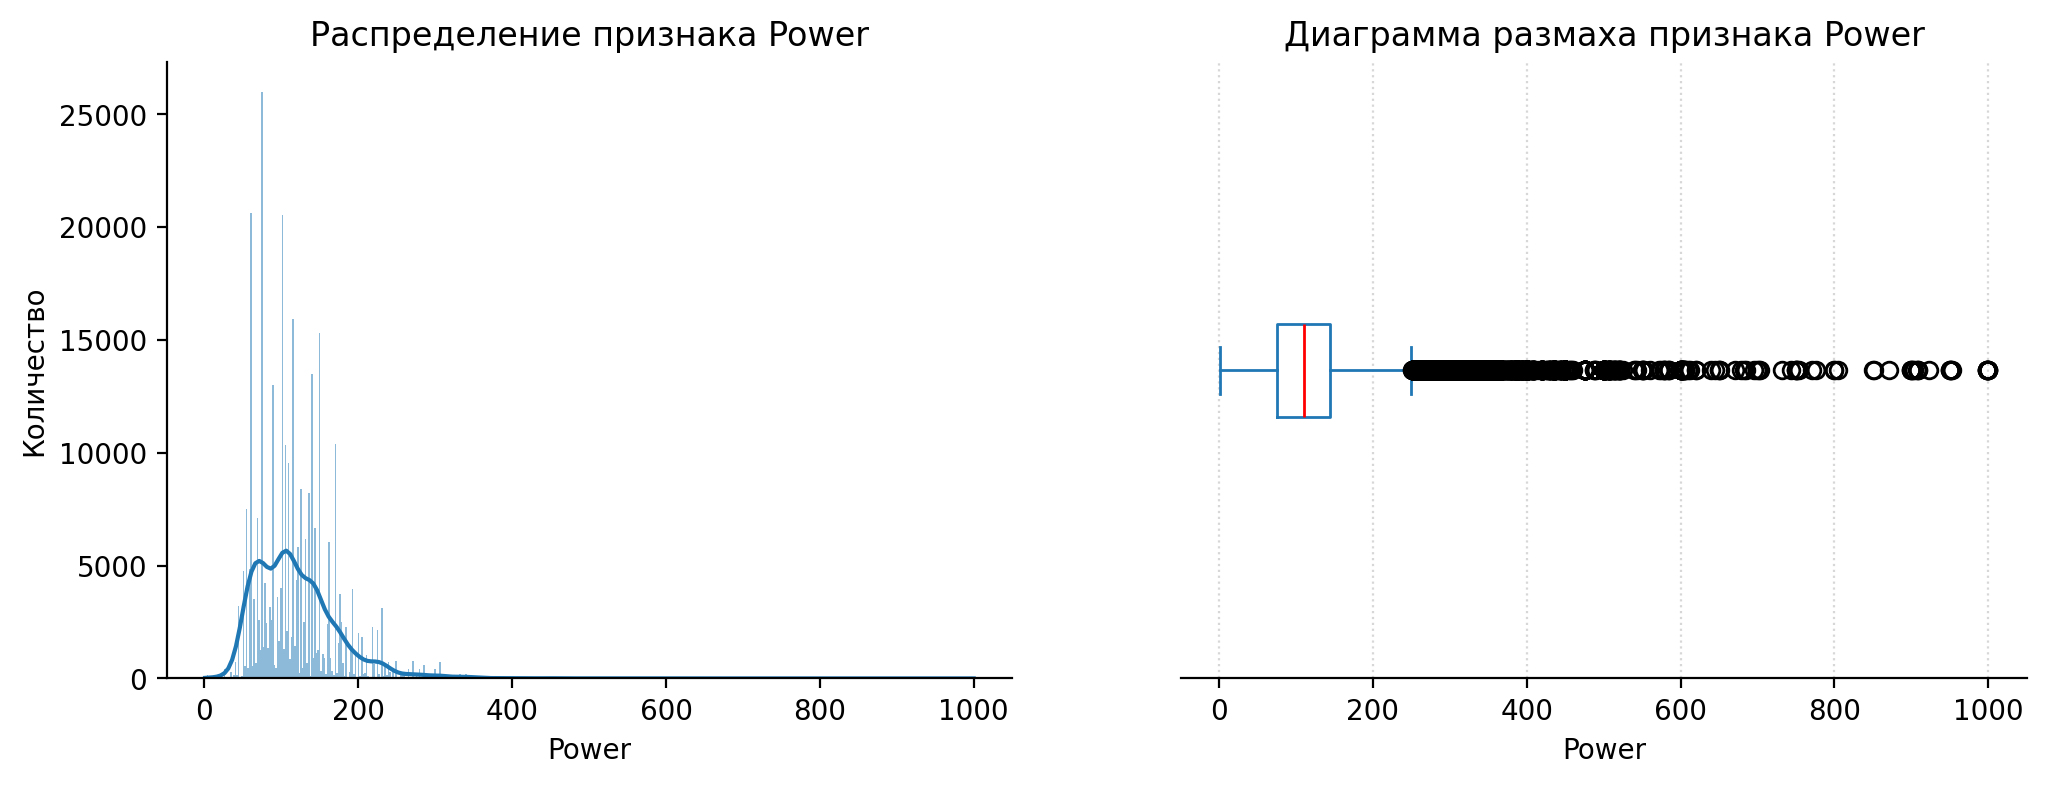

In [131]:
num_columns_bins = {
    'Price': 100,
    'RegistrationYear': autos['RegistrationYear'].max() - autos['RegistrationYear'].min() + 1,
    'Power': 30
}

for column, bins in num_columns_bins.items():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    sns.histplot(autos[column], ax=ax1, kde=True, kde_kws={'bw_method': 0.2}, linewidth=0)
    ax1.set_title(f'Распределение признака {column}')
    ax1.set_xlabel(column)
    ax1.set_ylabel('Количество')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    display_box(autos[column], column, ax2)
    
    plt.show()

#### Категориальные признаки

Изучим распределения категориальных признаков (сюда же добавим дискретный количественный признак `Kilometer`, который по своей сути категориальный).

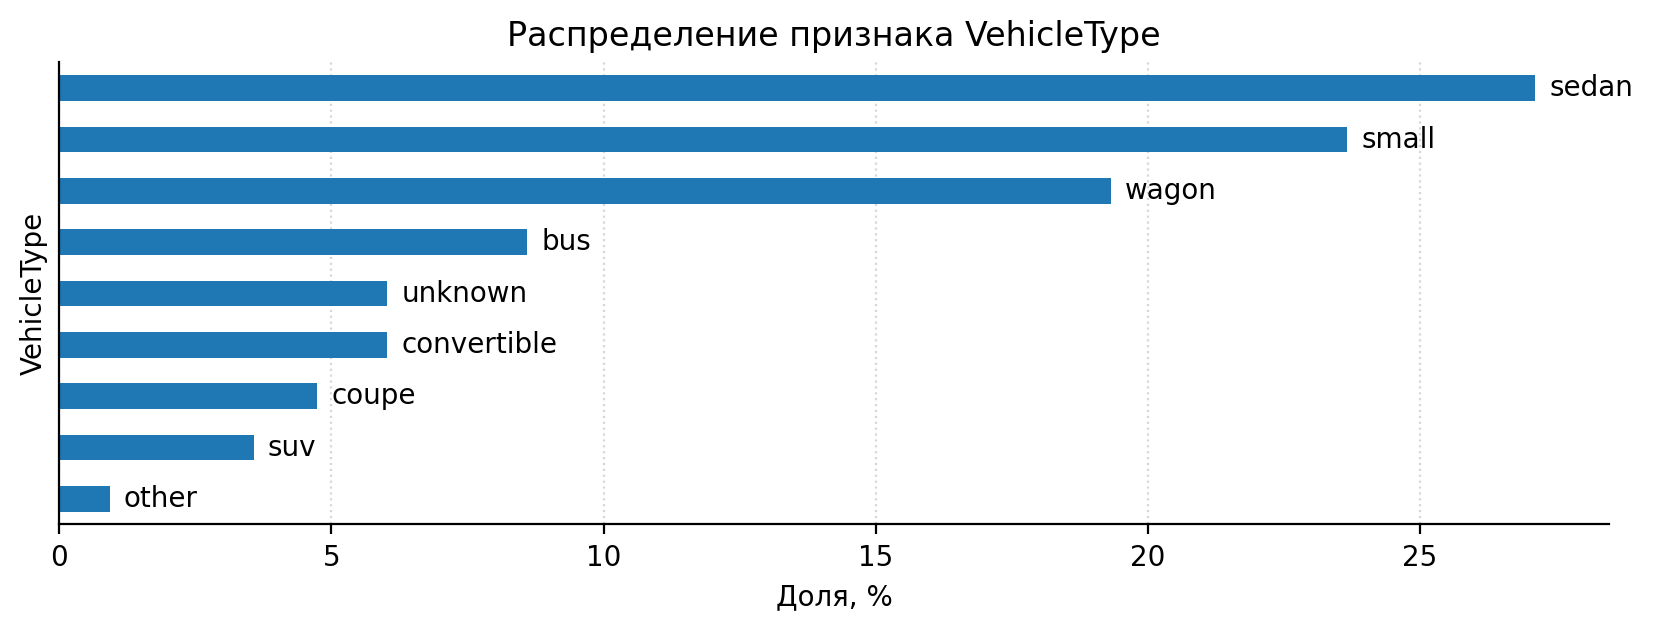

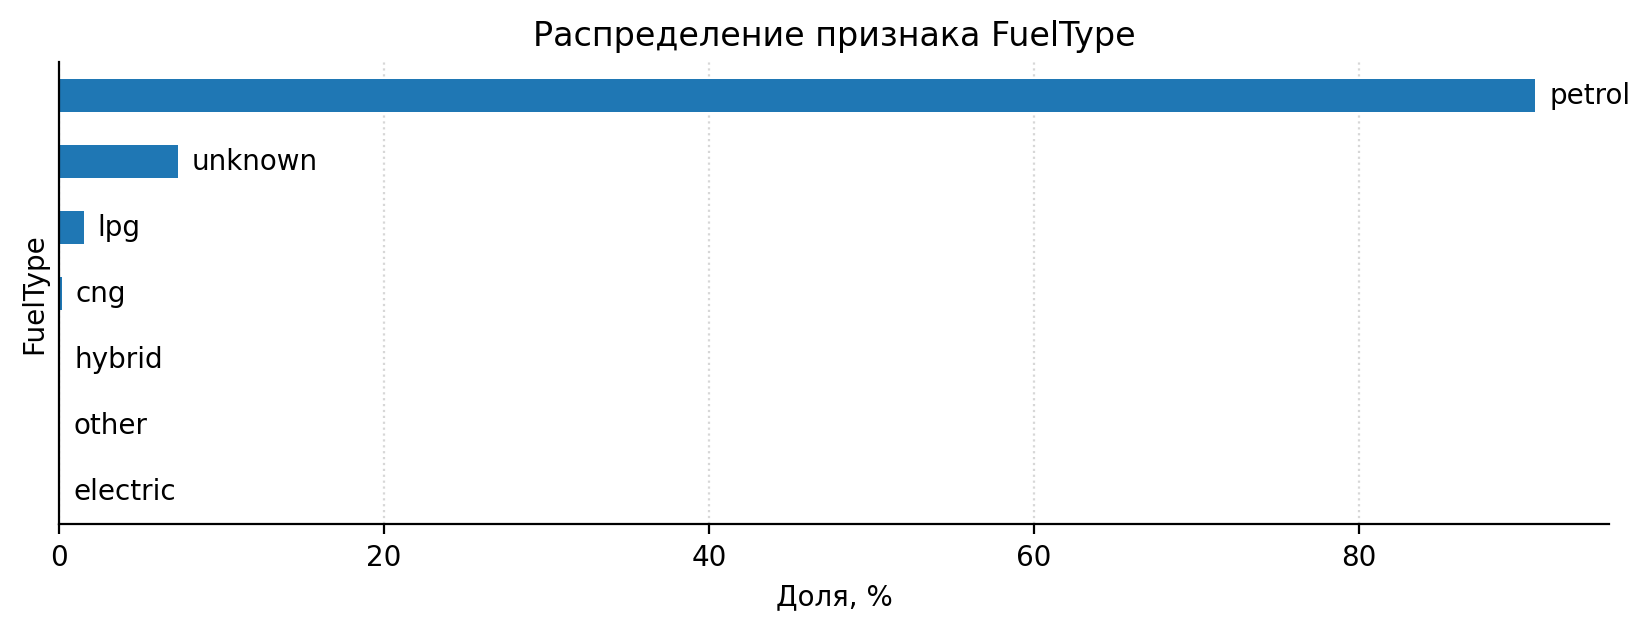

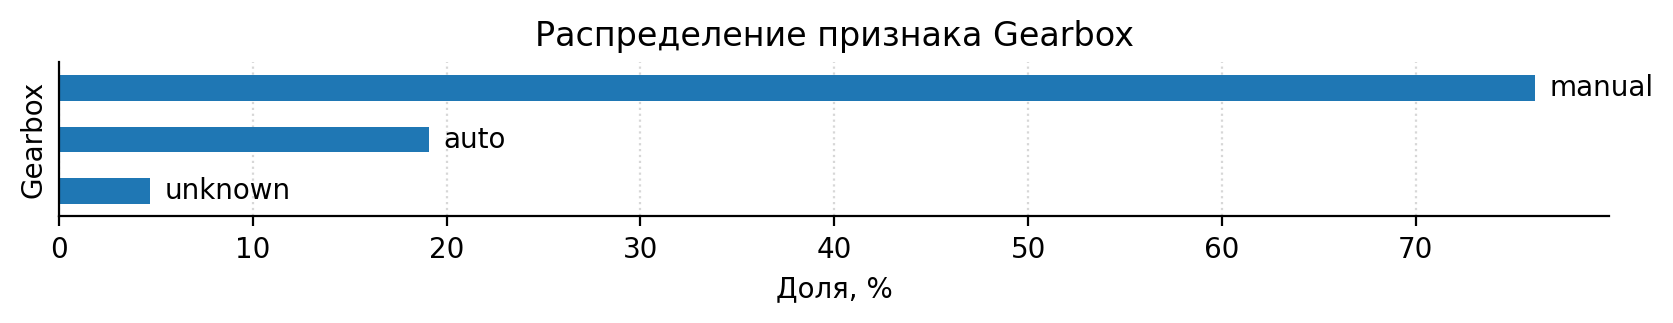

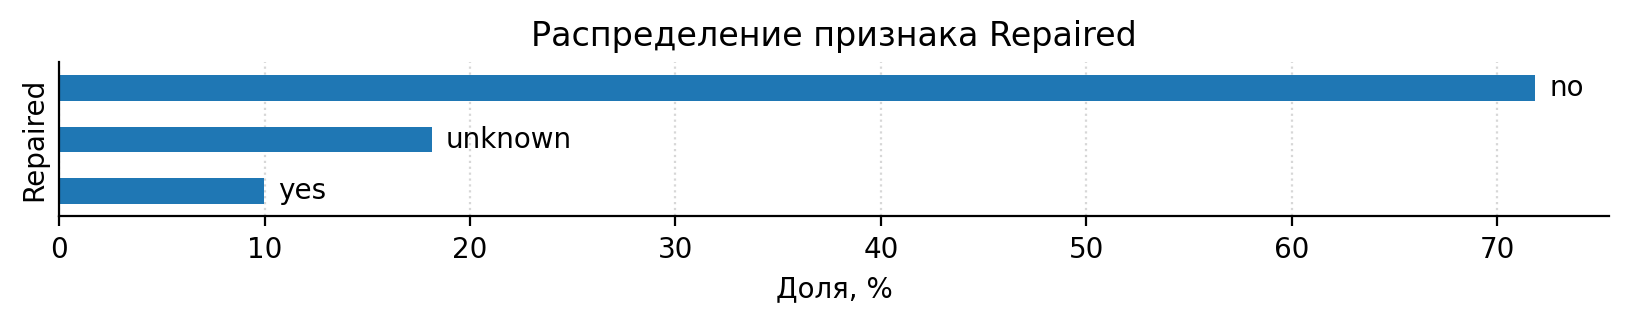

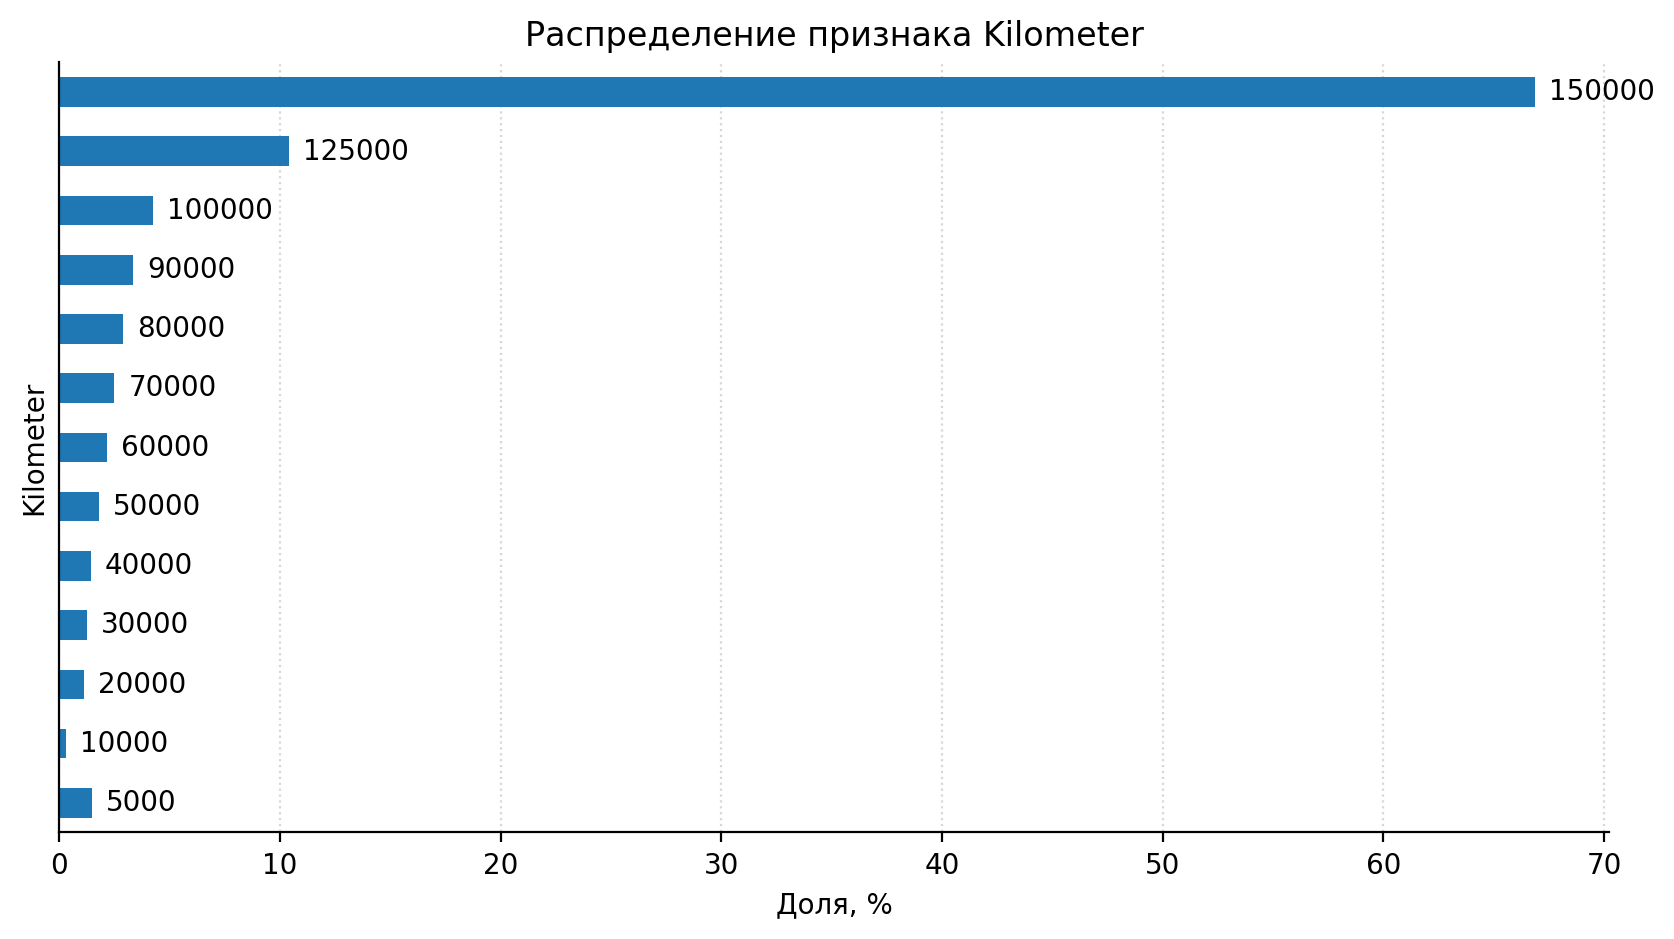

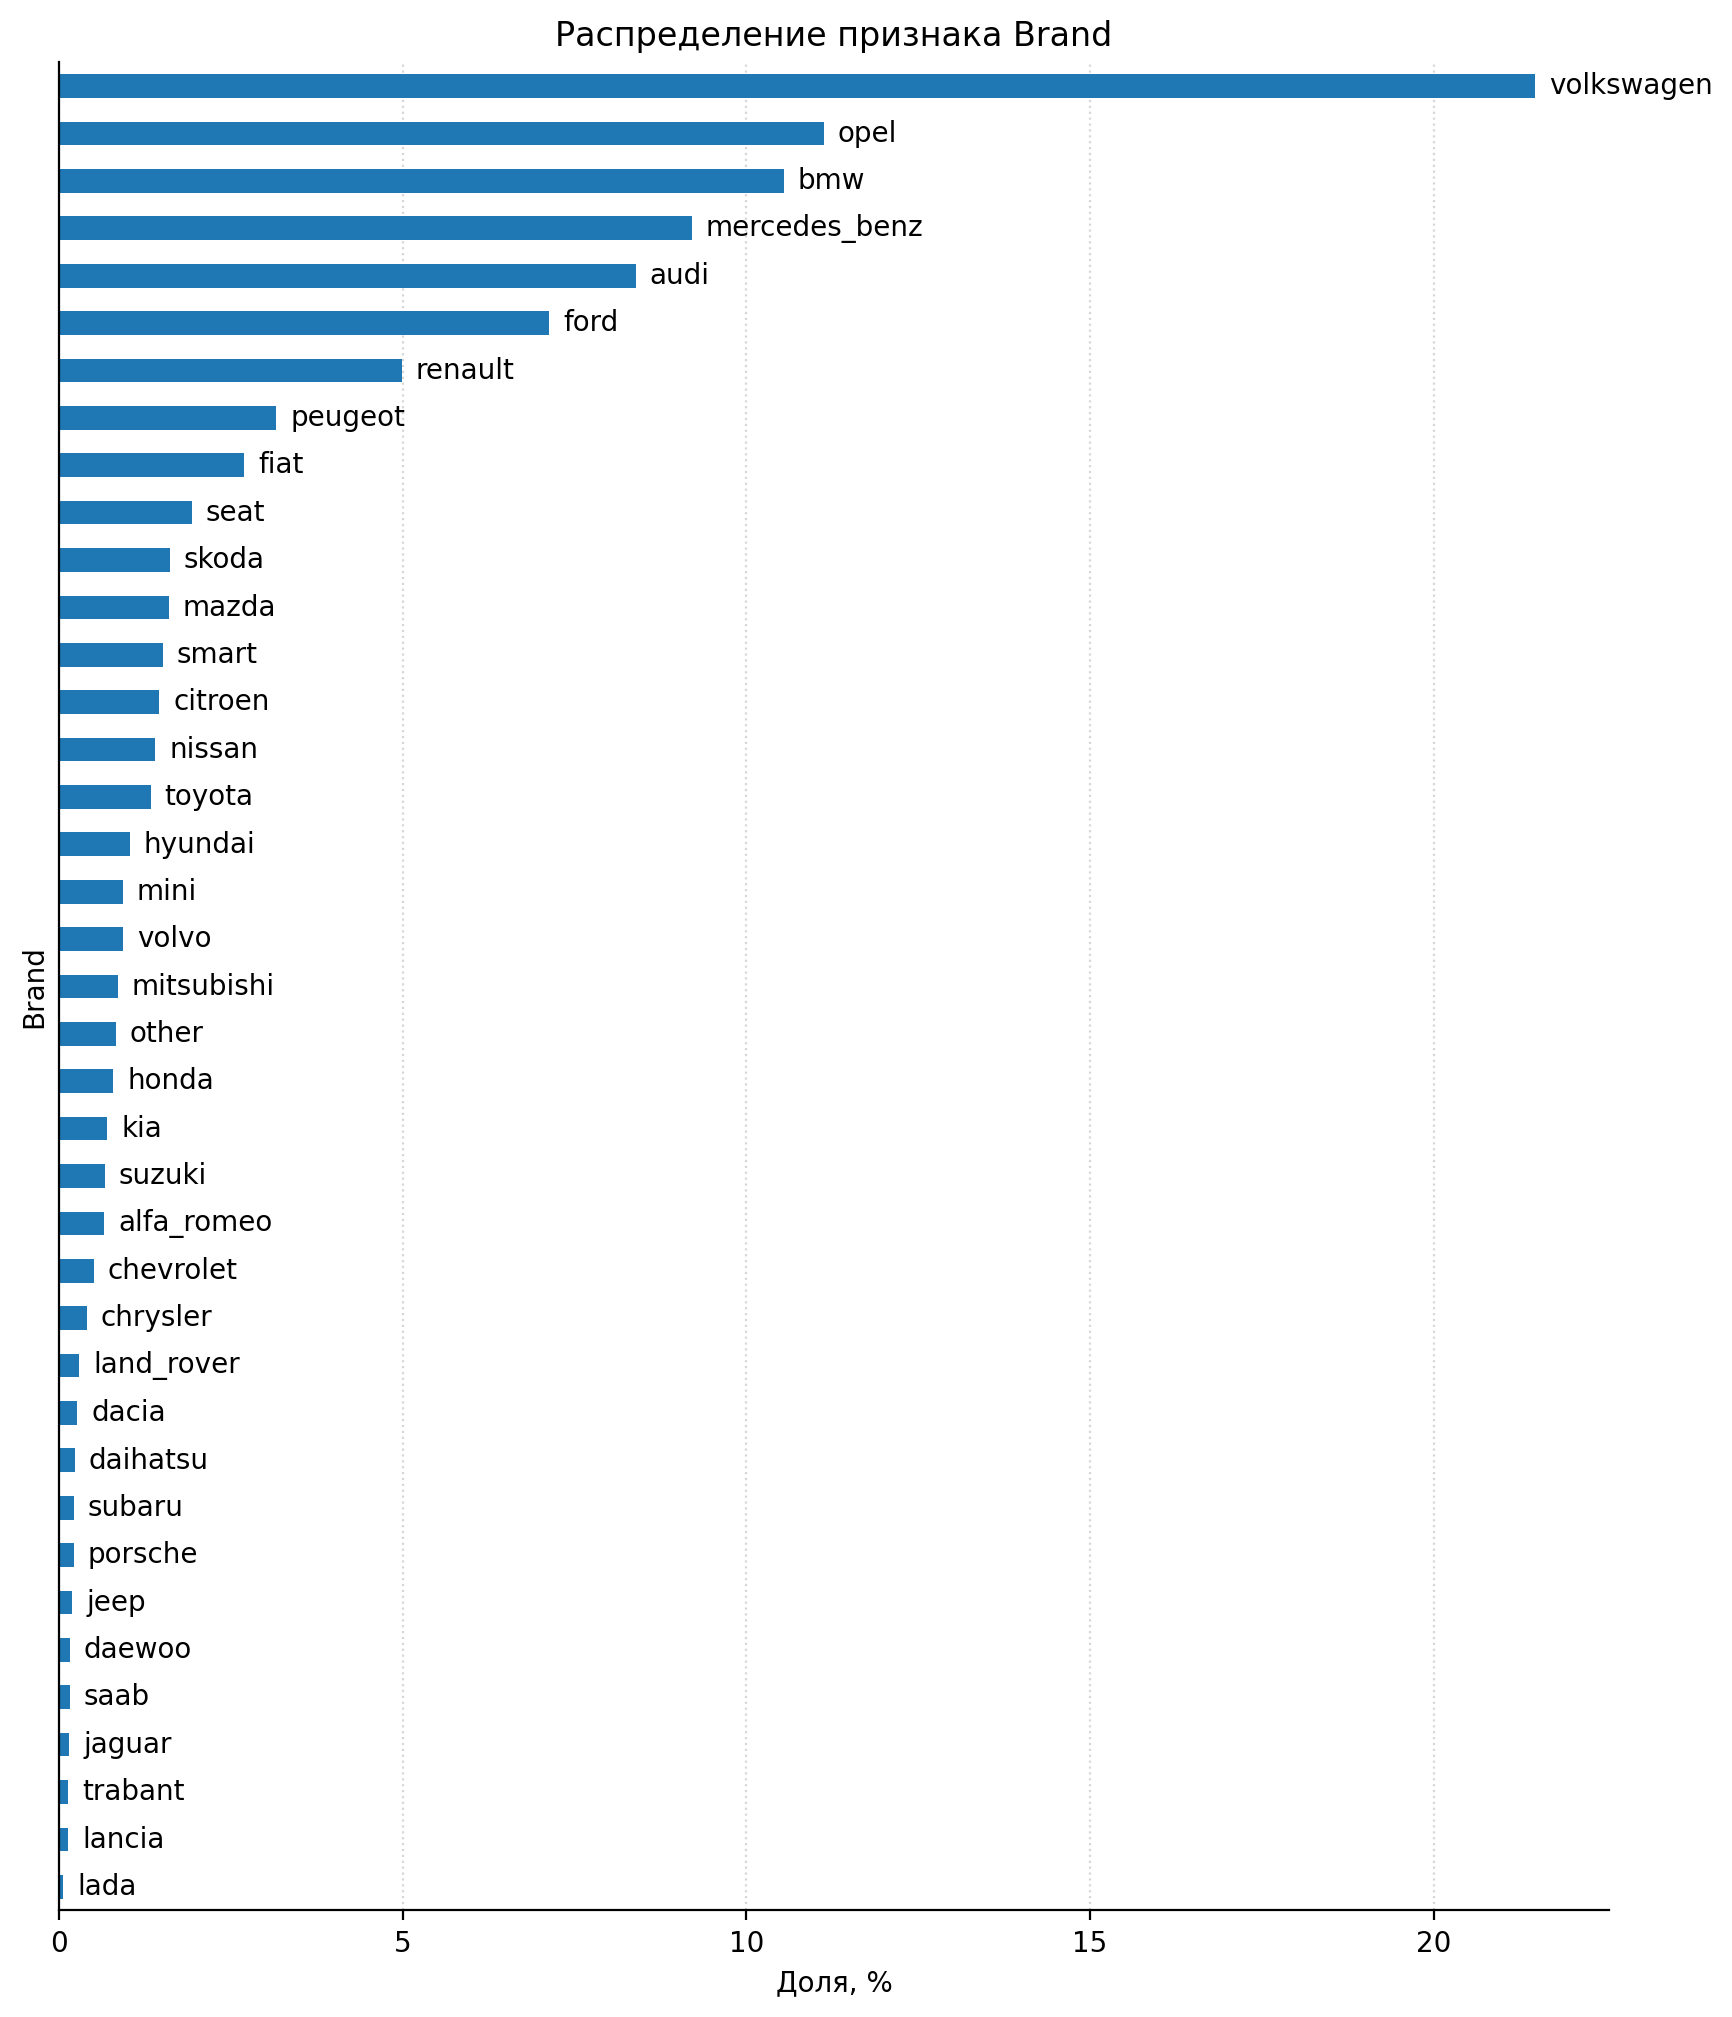

In [134]:
cat_columns_heights = {'VehicleType': 3, 'FuelType': 3, 'Gearbox': 1, 'Repaired': 1, 'Kilometer': 5, 'Brand': 12}

for column, height in cat_columns_heights.items():
    fig, ax = plt.subplots(figsize=(10, height))

    s = autos[column].value_counts(normalize=True) * 100
    if column == 'Kilometer':
        s = s.sort_index()
    else:
        s = s.sort_values()
    s.plot(kind='barh', ax=ax)
    ax.bar_label(ax.containers[0], labels=s.index, label_type='edge', padding=5)
    ax.set_title(f'Распределение признака {column}')
    ax.set_xlabel('Доля, %')
    ax.set_yticks([])
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='x', alpha=0.5, linestyle=':')
    
    plt.show()

#### Корреляция признаков

Рассчитаем коэффициенты корреляции Фи между всеми признаками. Посмотрим тепловую карту матрицы корреляций.

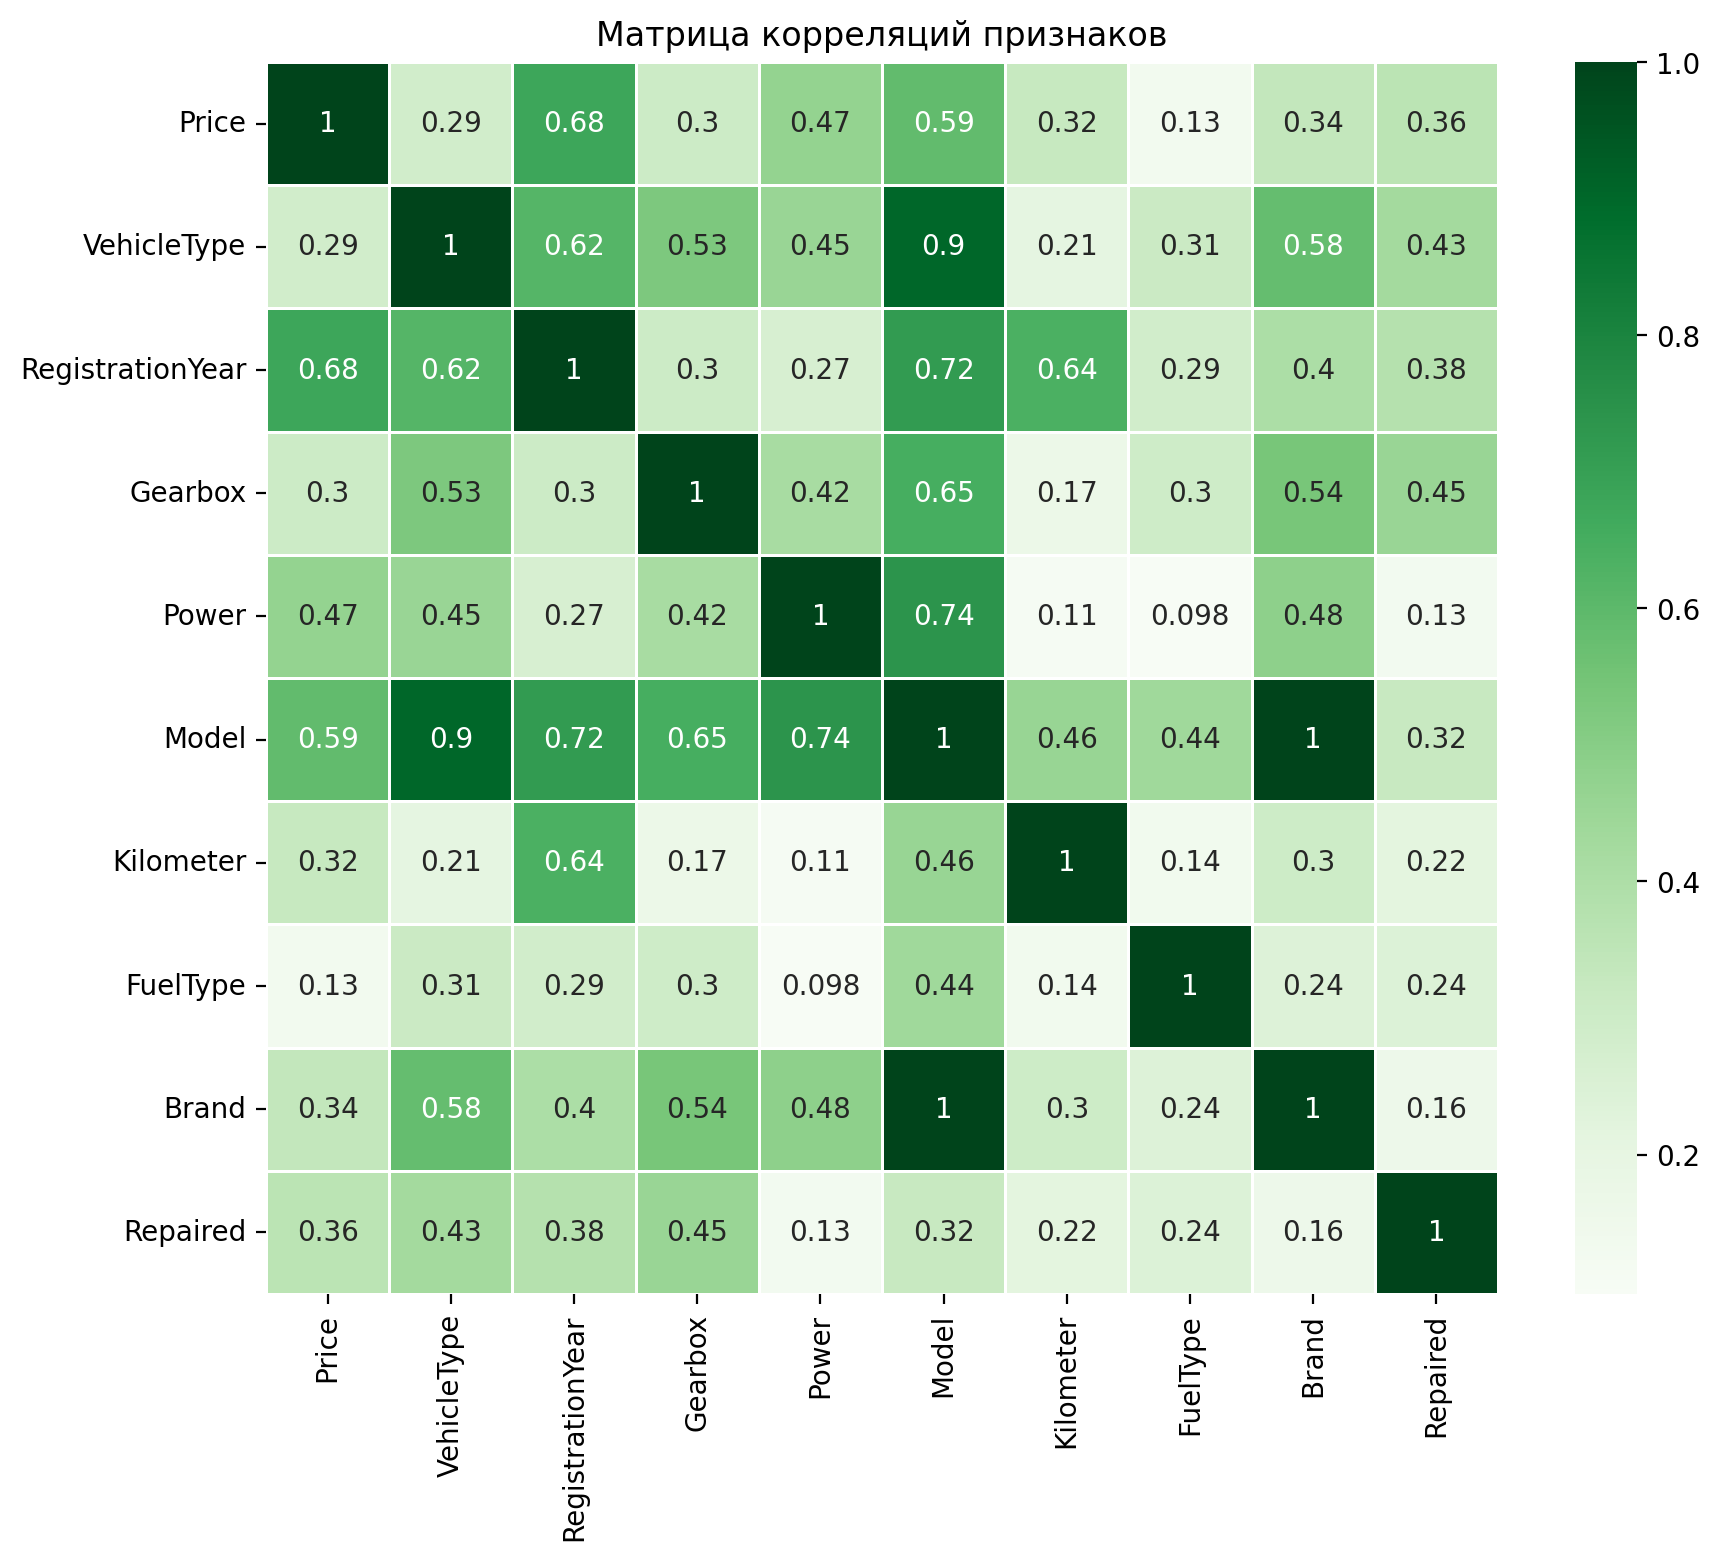

In [137]:
interval_columns = ['Price', 'Power']
corr_coefficients = autos.phik_matrix(interval_cols=interval_columns)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(corr_coefficients, annot=True, square=True, linewidths=0.5, cmap='Greens', ax=ax)
ax.set_title('Матрица корреляций признаков')
plt.show()

Можно отметить следующее:
- Обнаружена мультиколлинеарность признаков `Brand` и `Model`. Вполне ожидаемо, учитывая склеивание марки и модели автомобиля.
- Обнаружена заметная корреляция признаков `RegistrationYear` и `Model` с целевым признаком `Price`.

Посмотрим на диаграммы рассеяния количественных признаков с целевым признаком (с разбивкой по признаку была машина в ремонте или нет). Для построения диаграмм семплируем датафрейм `autos`, не будем использовать весь объем данных.

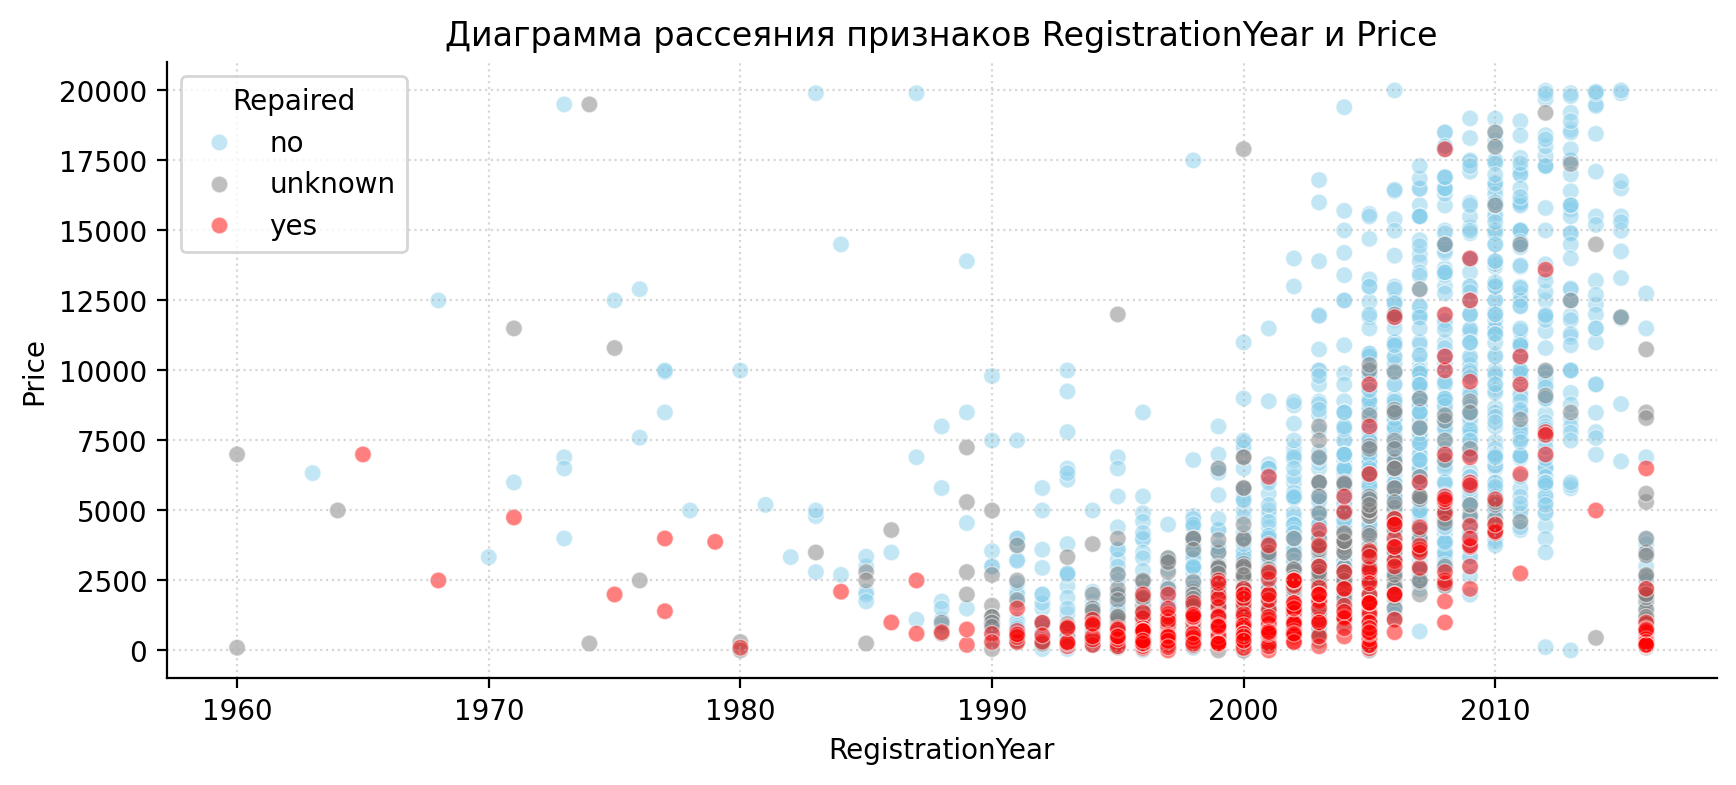

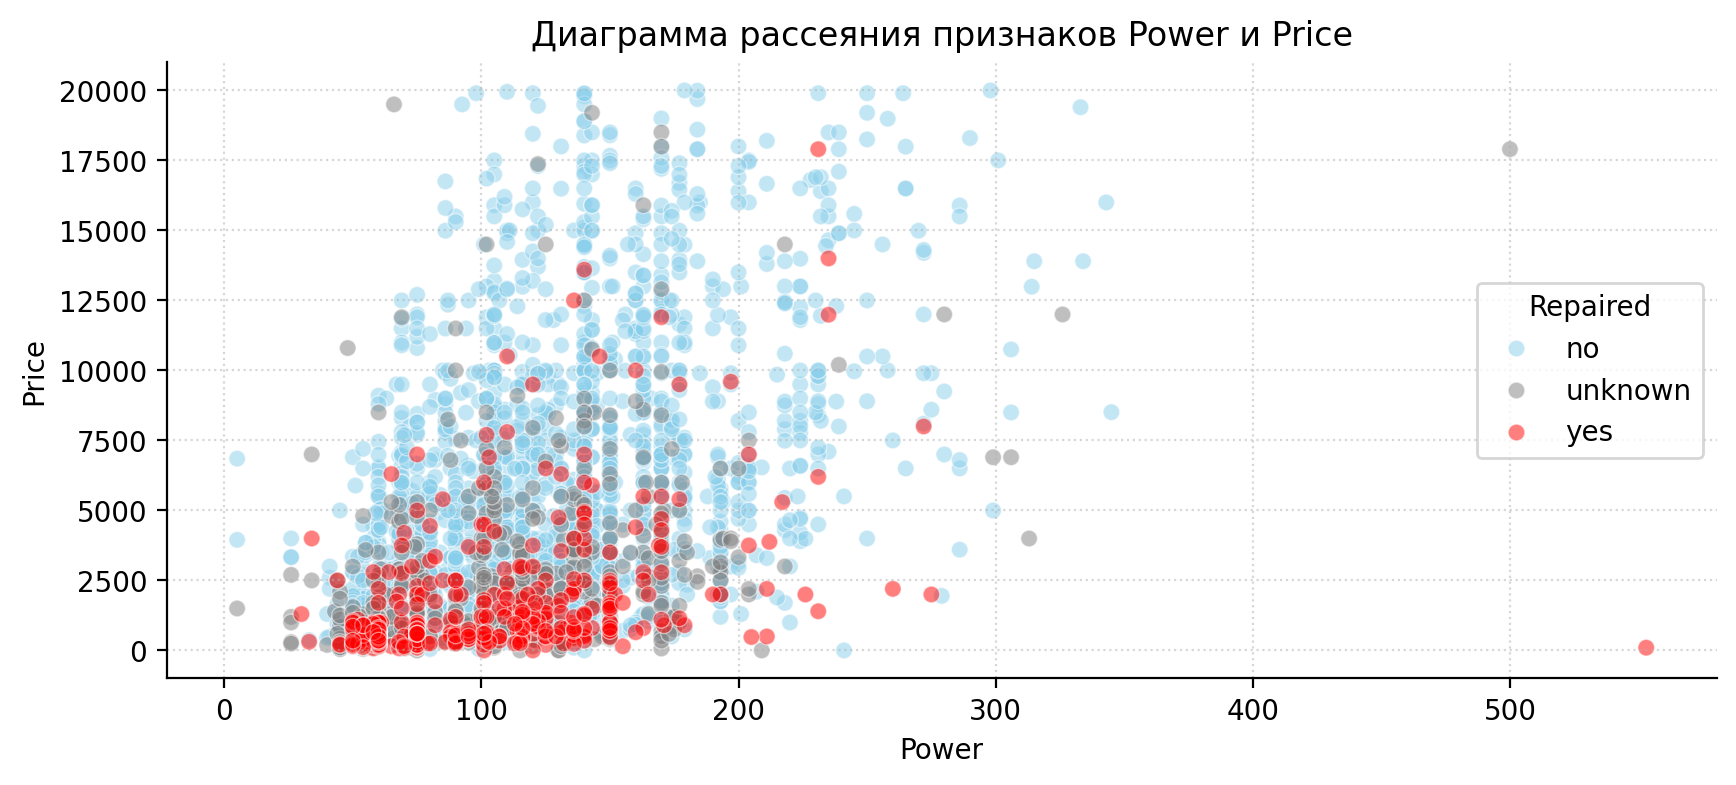

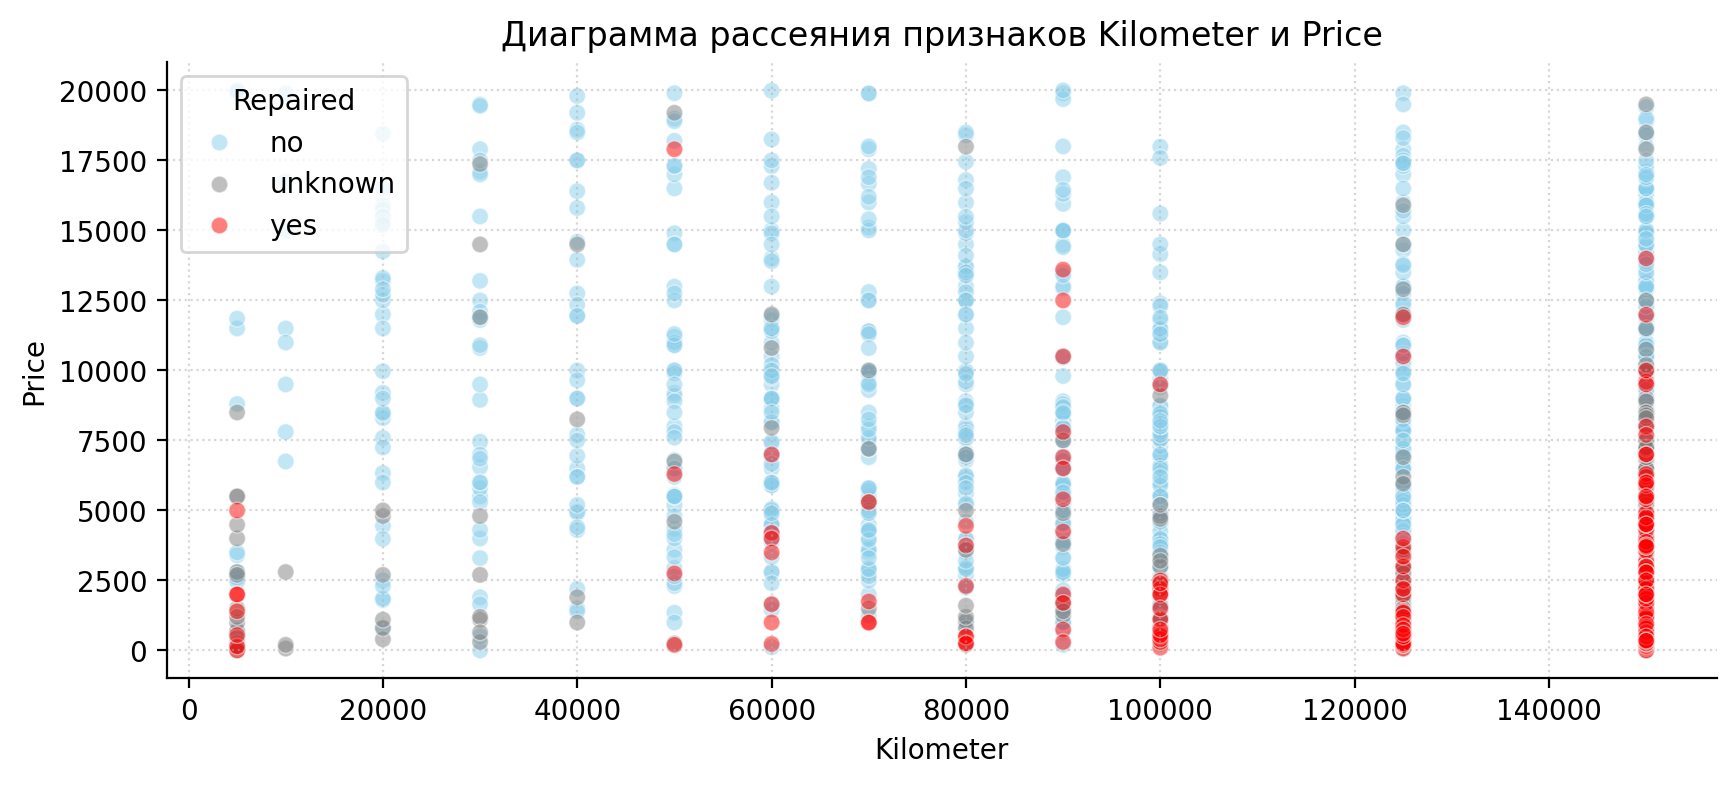

In [140]:
autos_sample = autos.sample(frac=0.01, random_state=RANDOM_STATE).sort_values('Repaired')
num_columns = ['RegistrationYear', 'Power', 'Kilometer']

for column in num_columns:
    fig, ax = plt.subplots(figsize=(10, 4))

    sns.scatterplot(data=autos_sample, x=column, y='Price', hue='Repaired', 
                    ax=ax, marker='o', alpha=0.5, palette=['skyblue', 'gray', 'red'])
    ax.set_title(f'Диаграмма рассеяния признаков {column} и Price')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(alpha=0.5, linestyle=':')
    
    plt.show()
    
del autos_sample

#### Результаты исследовательского анализа

По результатам **исследовательского анализа данных** можно отметить следующее:
- количественные признаки распределены не нормально, есть выбросы;
- у количественных признаков разные диапазоны значений — необходимо масштабирование;
- у категориальных признаков наблюдается дисбаланс классов;
- обнаружена мультиколлинеарность марки и модели автомобиля, которая может негативно повлиять на качество моделей;
- у цены есть заметная корреляция с годом регистрации и моделью автомобиля.

## Обучение моделей

### Подготовка выборок

Разделим данные на тренировочную и тестовую выборки.

In [146]:
X_train, X_test, y_train, y_test = train_test_split(
    autos.drop('Price', axis=1),
    autos['Price'],
    test_size=0.25, 
    random_state=RANDOM_STATE
)

### Дамми-модель

Начнем с дамми-модели, предсказывающей цену на основе среднего значения в тренировочной выборке.

In [149]:
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(X_train, y_train)

rmse_score = mean_squared_error(y_test, dummy_model.predict(X_test), squared=False)
f'RMSE: {rmse_score:.2f} евро'

'RMSE: 4530.80 евро'

### Линейная регрессия LinearRegression

Подготовим `ColumnTransformer` для кодирования и масштабирования входных признаков.

In [152]:
ohe_transformer = Pipeline(
    steps=[('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
           ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]
)

num_transformer = Pipeline(
    steps=[('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
           ('scaler', MinMaxScaler())]
)

data_preprocessor = ColumnTransformer(
    transformers=[('ohe', ohe_transformer, ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired']),
                  ('num', num_transformer, ['RegistrationYear', 'Power', 'Kilometer'])], 
    remainder='drop', 
    verbose_feature_names_out=False
)

Подготовим пайплан, включающий `ColumnTransformer` для кодирования и масштабирования входных признаков и модель линейной регрессии `LinearRegression`. Подберем гиперпараметры с помощью класса `GridSearchCV`. Для оценки качества модели применим метрику RMSE — корень среднеквадратичной ошибки.

In [154]:
%%time

model_pipe = Pipeline(
    steps=[('preprocessor', data_preprocessor),
           ('model', LinearRegression())]
)

model_grid = [{
    'preprocessor__ohe__encoder__drop': ['first', None],
    'model__fit_intercept': [True, False]
}]

model_search_lr = GridSearchCV(model_pipe, model_grid, cv=3, n_jobs=-1, scoring='neg_root_mean_squared_error')
model_search_lr.fit(X_train, y_train)
pass

CPU times: total: 14.7 s
Wall time: 22.9 s


Посмотрим на результаты работы модели и добавим их в статистику.

In [156]:
results = get_cv_results(model_search_lr)
models_stat = ModelsStat()
models_stat.add('LinearRegression', *results)

"Гиперпараметры лучшей модели: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}"

'Время обучения: 7.44 s'

'Время предсказания: 0.71 s'

'RMSE при кросс-валидации: 2716.42 евро'

### Модель дерева решений DecisionTreeRegressor

Подготовим `ColumnTransformer` для кодирования и масштабирования входных признаков.

In [159]:
ord_transformer = Pipeline(
    steps=[('imputer_before', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
           ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
           ('imputer_after', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))]
)

num_transformer = Pipeline(
    steps=[('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
           ('scaler', MinMaxScaler())]
)

data_preprocessor = ColumnTransformer(
    transformers=[('ord', ord_transformer, ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired']),
                  ('num', num_transformer, ['RegistrationYear', 'Power', 'Kilometer'])], 
    remainder='drop', 
    verbose_feature_names_out=False
)

Подготовим пайплан, включающий `ColumnTransformer` для кодирования и масштабирования входных признаков и модель дерева решений `DecisionTreeRegressor`. Подберем гиперпараметры с помощью класса `GridSearchCV`. Для оценки качества модели применим метрику RMSE — корень среднеквадратичной ошибки.

In [161]:
%%time

model_pipe = Pipeline(
    steps=[('preprocessor', data_preprocessor),
           ('model', DecisionTreeRegressor(random_state=RANDOM_STATE))]
)

model_grid = [{
    'model__max_depth': [5, 10, 15]
}]

model_search_dtr = GridSearchCV(model_pipe, model_grid, cv=5, n_jobs=-1, scoring='neg_root_mean_squared_error')
model_search_dtr.fit(X_train, y_train)
pass

CPU times: total: 4.62 s
Wall time: 6.82 s


Посмотрим на результаты работы модели и добавим их в статистику.

In [163]:
results = get_cv_results(model_search_dtr)
models_stat.add('DecisionTreeRegressor', *results)

"Гиперпараметры лучшей модели: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 15, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}"

'Время обучения: 1.41 s'

'Время предсказания: 0.11 s'

'RMSE при кросс-валидации: 1934.66 евро'

### Модель градиентного бустинга CatBoostRegressor

Подготовим пайплан, включающий модель градиентного бустинга `CatBoostRegressor`. Подберем гиперпараметры с помощью класса `GridSearchCV`. Для оценки качества модели применим метрику RMSE — корень среднеквадратичной ошибки.

In [166]:
%%time

model_pipe = Pipeline(
    steps=[('model', CatBoostRegressor(cat_features=['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired'],
                                       iterations=20, loss_function='RMSE', verbose=False, 
                                       random_state=RANDOM_STATE))]
)

model_grid = [{
    'model__grow_policy': ['Depthwise', 'SymmetricTree']
}]

model_search_cbr = GridSearchCV(model_pipe, model_grid, cv=5, n_jobs=-1, scoring='neg_root_mean_squared_error')
model_search_cbr.fit(X_train, y_train)
pass

CPU times: total: 14.6 s
Wall time: 22.6 s


Посмотрим на результаты работы модели и добавим их в статистику.

In [168]:
results = get_cv_results(model_search_cbr)
models_stat.add('CatBoostRegressor', *results)

"Гиперпараметры лучшей модели: {'iterations': 20, 'loss_function': 'RMSE', 'verbose': False, 'random_state': 42, 'cat_features': ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired'], 'grow_policy': 'Depthwise'}"

'Время обучения: 11.68 s'

'Время предсказания: 0.58 s'

'RMSE при кросс-валидации: 1807.97 евро'

### Модель градиентного бустинга LGBMRegressor

Подготовим пайплан, включающий модель градиентного бустинга `LGBMRegressor`. Подберем гиперпараметры с помощью класса `GridSearchCV`. Для оценки качества модели применим метрику RMSE — корень среднеквадратичной ошибки.

In [171]:
%%time

X_train_lgbmr = X_train
for column in ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']:
    X_train_lgbmr[column] = X_train_lgbmr[column].astype('category')

model_pipe = Pipeline(
    steps=[('model', LGBMRegressor(metric='rmse', verbose=0, force_col_wise=True, random_state=RANDOM_STATE, max_bin=330))]
)

model_grid = [{
    'model__boosting_type': ['gbdt', 'dart']
}]

model_search_lgbmr = GridSearchCV(model_pipe, model_grid, cv=5, n_jobs=-1, scoring='neg_root_mean_squared_error')
model_search_lgbmr.fit(X_train_lgbmr, y_train)
pass

CPU times: total: 7.53 s
Wall time: 21.9 s


Посмотрим на результаты работы модели и добавим их в статистику.

In [173]:
results = get_cv_results(model_search_lgbmr)
models_stat.add('LGBMRegressor', *results)

"Гиперпараметры лучшей модели: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'metric': 'rmse', 'verbose': 0, 'force_col_wise': True, 'max_bin': 330}"

'Время обучения: 8.36 s'

'Время предсказания: 0.29 s'

'RMSE при кросс-валидации: 1654.05 евро'

## Анализ моделей

Посмотрим на результаты обучения и оценку качества моделей.

In [176]:
models_stat.to_frame()

,Модель,"Время обучения, сек","Время предсказания, сек","RMSE на кросс-валидации, евро",Параметры,Модель подходит
0,LGBMRegressor,8.36,0.29,1654.05,"{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'metric': 'rmse', 'verbose': 0, 'force_col_wise': True, 'max_bin': 330}",True
1,CatBoostRegressor,11.68,0.58,1807.97,"{'iterations': 20, 'loss_function': 'RMSE', 'verbose': False, 'random_state': 42, 'cat_features': ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired'], 'grow_policy': 'Depthwise'}",True
2,DecisionTreeRegressor,1.41,0.11,1934.66,"{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 15, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}",True
3,LinearRegression,7.44,0.71,2716.42,"{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}",False


В процессе исследования были использованы следующие модели:
- линейная регрессия `LinearRegression`;
- модель дерева решений `DecisionTreeRegressor`;
- модель градиентного бустинга `CatBoostRegressor`;
- модель градиентного бустинга `LGBMRegressor`.

Исходя из критерия заказчика (значение метрики RMSE должно быть меньше 2500), линейная регрессия `LinearRegression` не подходит.

Заказчику важны качество предсказания, время обучения модели и время предсказания модели. Однако приоритеты этих критериев не расставлены. Поскольку новые модели автомобилей появляются не так часто, и цены на автомобли хоть и подвержены колебаниям, но не меняются кардинально каждый день, можно предположить, что качество предсказания и скорость предсказания является более важными критериями, чем скорость обучения (переобучать модель нужно гораздо реже, чем делать предсказания при добавлении новых объявлений о продаже).

Поэтому заказчику **рекомендуется использовать модель градиентного бустинга `LGBMRegressor`**, которая обгоняет другие модели по метрике RMSE, при этом по времени предсказания не сильно отстает от модели `DecisionTreeRegressor`.

Посмотрим на метрику RMSE выбранной модели `LGBMRegressor` на тестовых данных.

In [179]:
X_test_lgbmr = X_test
for column in ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']:
    X_test_lgbmr[column] = X_test_lgbmr[column].astype('category')

predict = model_search_lgbmr.predict(X_test_lgbmr)
score = mean_squared_error(y_test, predict, squared=False)
display(f'RMSE на тестовой выборке: {score:.2f} евро');

'RMSE на тестовой выборке: 1642.79 евро'

Посмотрим на распределение остатков выбранной модели.

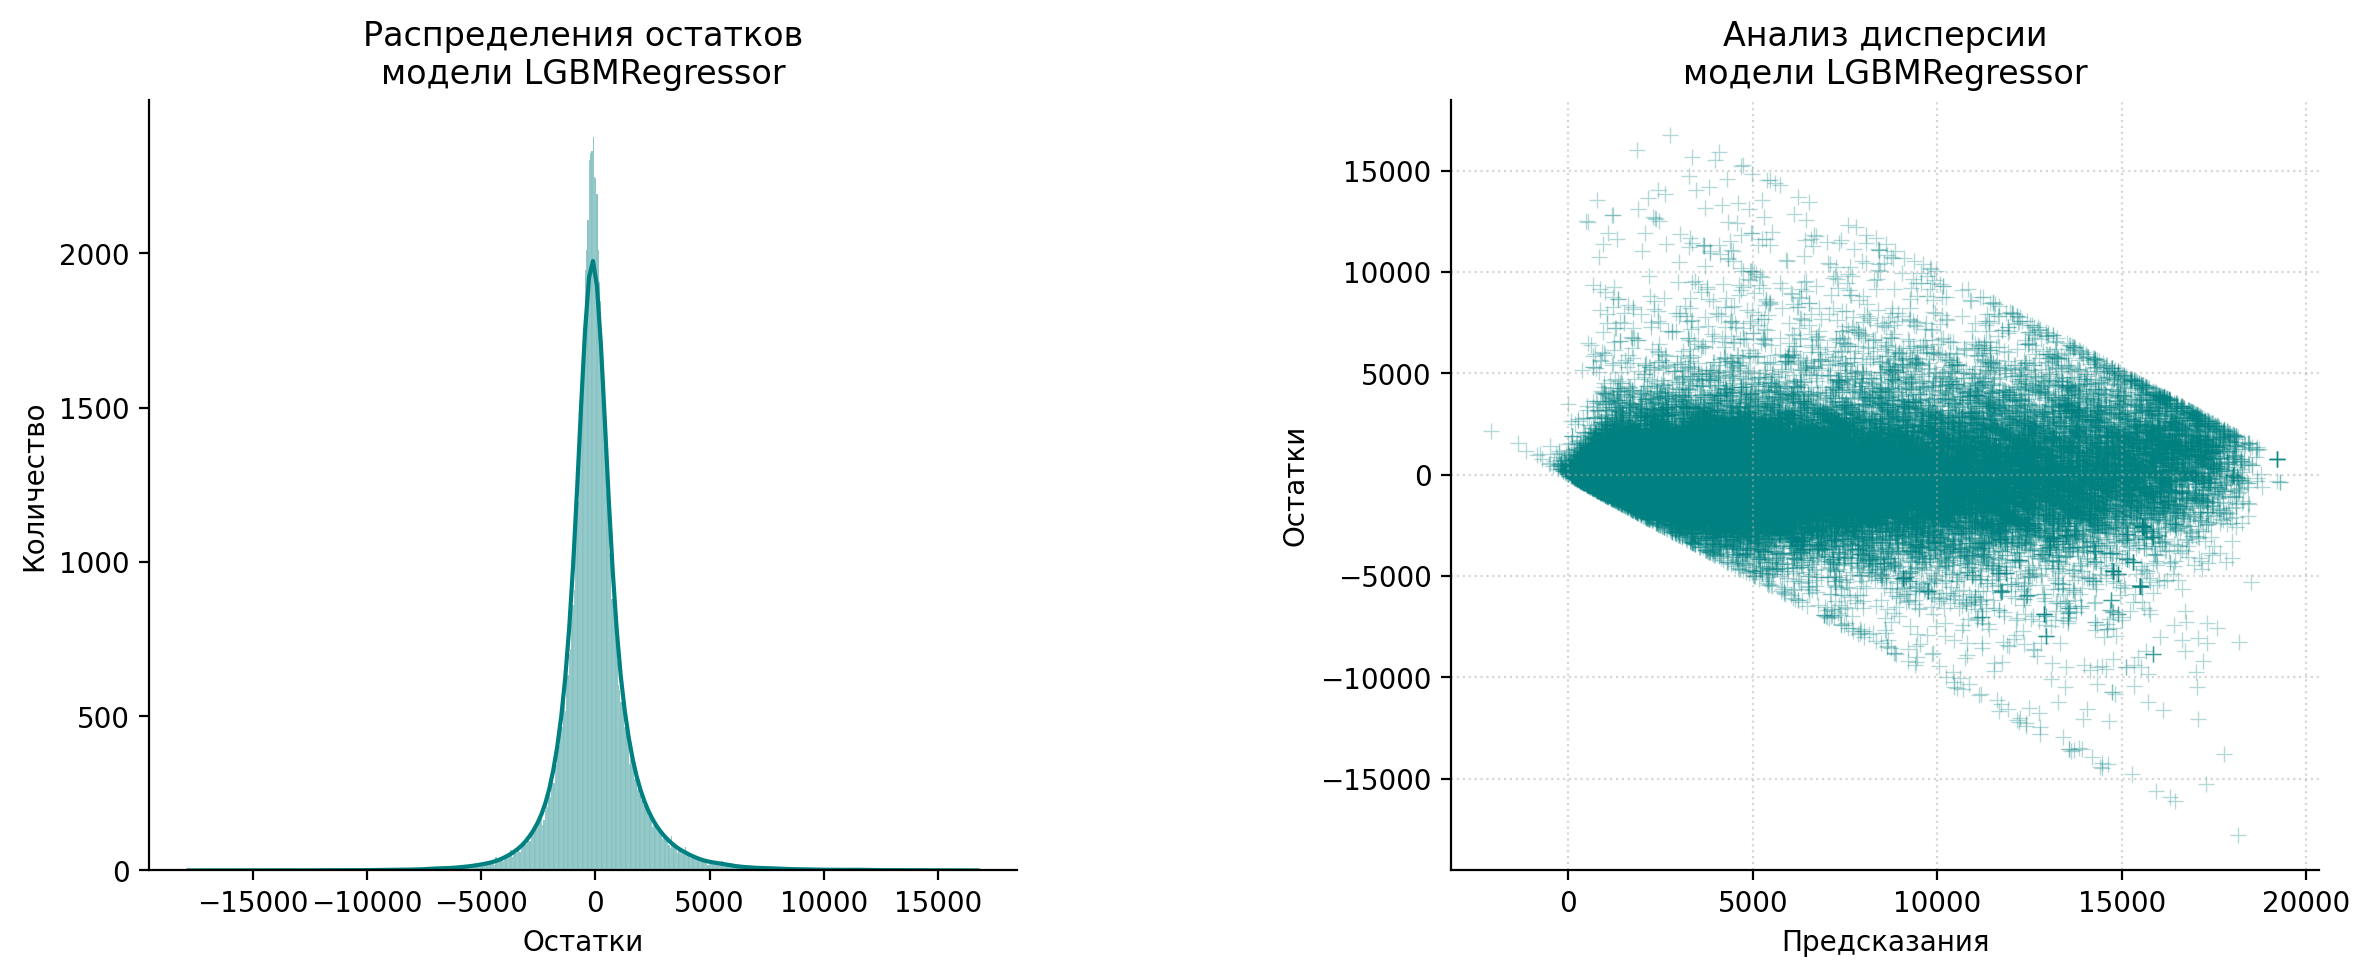

In [181]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.subplots_adjust(wspace=0.5)
display_residuals(y_test, predict, 'LGBMRegressor', axes)
plt.show()

Остатки распределены нормально, со средним около 0. Оценим важность признаков выбранной модели.

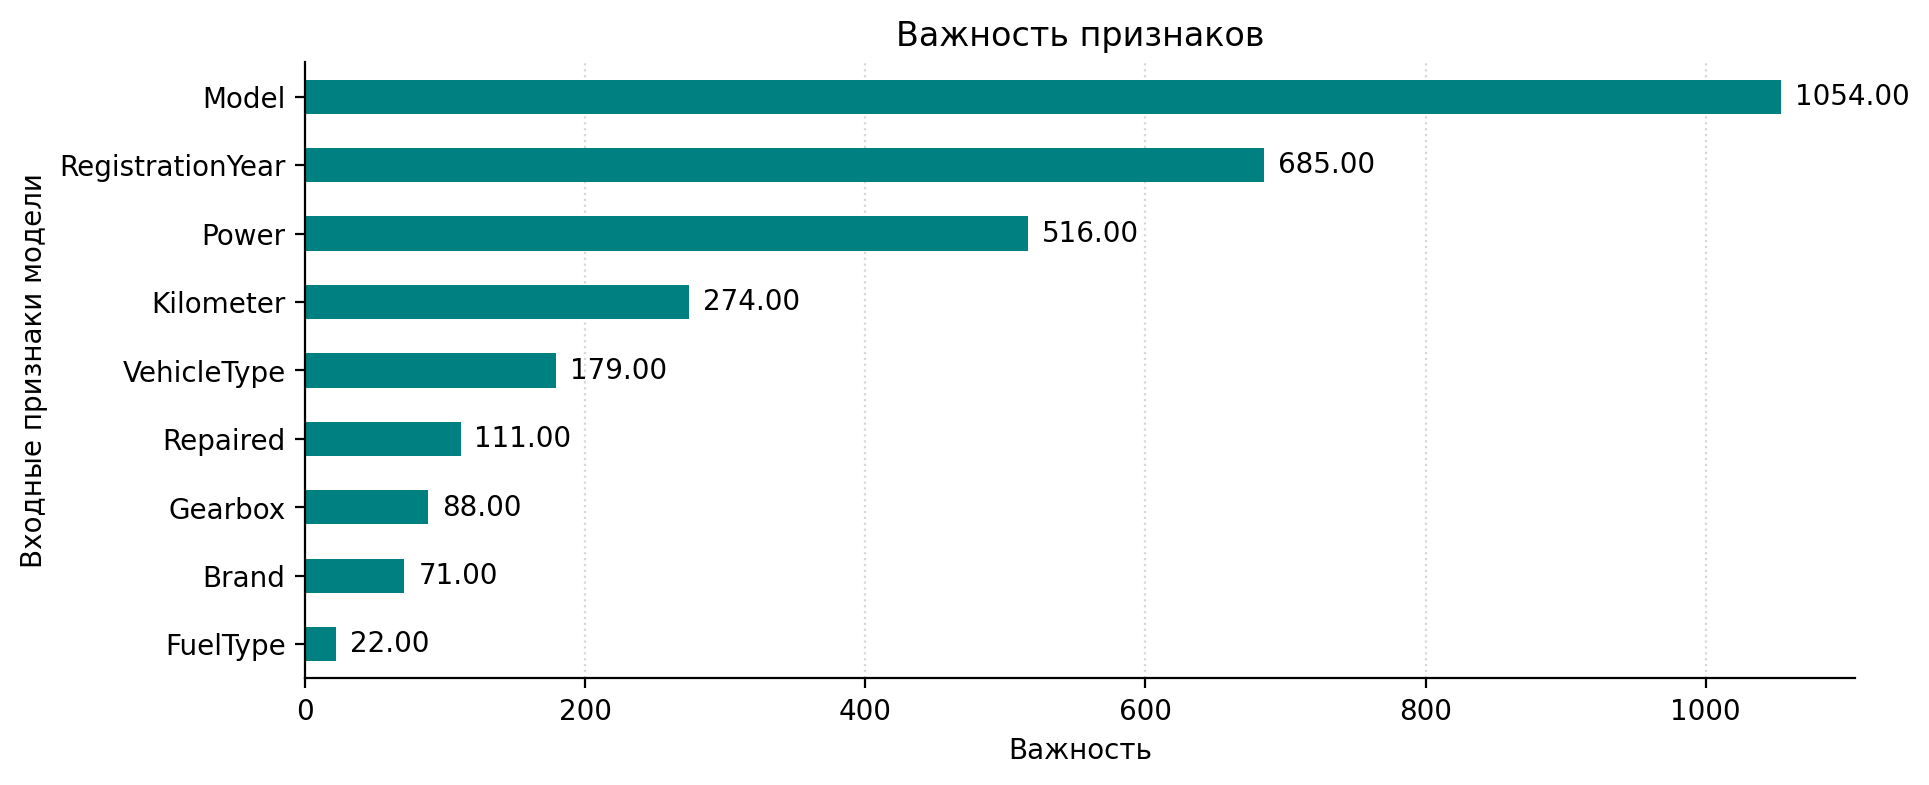

In [183]:
feature_importances = pd.Series(
    data=model_search_lgbmr.best_estimator_.named_steps['model'].feature_importances_,
    index=X_train_lgbmr.columns
).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 4))

feature_importances.plot(kind='barh', ax=ax, color='teal')
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge', padding=5)
ax.set_title('Важность признаков')
ax.set_xlabel('Важность')
ax.set_ylabel('Входные признаки модели')
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', alpha=0.5, linestyle=':')

plt.show()

## Общий вывод

В ходе исследования обработаны и проанализированы данные о технических характеристиках, комплектации и ценах автомобилей. Построены модели, предсказывающие цены на автомобили. Построенные модели проанализированы, и выбрана модель, наиболее подходящая под критерии заказчика.

В результате **предобработки данных** было удалено ~7% данных. Заполнены пропущенные значения и обработаны аномалии в признаках. Также было удалено 6 неинформативных признаков.

По результатам **исследовательского анализа данных** можно отметить следующее:
- количественные признаки распределены не нормально, есть выбросы;
- у количественных признаков разные диапазоны значений — необходимо масштабирование;
- у категориальных признаков наблюдается дисбаланс классов;
- обнаружена мультиколлинеарность марки и модели автомобиля, которая может негативно повлиять на качество моделей;
- у цены есть заметная корреляция с годом регистрации и моделью автомобиля.

По результатам **обучения и анализа моделей**, предсказывающих цены на автомобили, заказчику рекомендуется использовать модель градиентного бустинга `LGBMRegressor`, которая удовлетворяет критерию оценки качества (значение метрики RMSE должно быть меньше 2500), а также обладает приемлемыми временами обучения и предсказания.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей